<a href="https://colab.research.google.com/github/Ether3alInfinity/Elec301-Musheen-Traynin-Project/blob/main/Machine_Training_Model_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Setup

In [ ]:
from google.colab import drive, files
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import numpy as np
import os
from scipy.io import wavfile
from scipy.fft import fft
import scipy

import sys
import importlib
import time
import math

# Sklearn functions are useful for generating train/test splits, and metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn import svm

# pytorch
import torch
import torch.utils.data as tdata

# Plotting
#import plotly.graph_objects as go
#from ipywidgets import interact

import pandas as pd

import librosa
import librosa.display
from sklearn.decomposition import PCA

#!pip install praat-parselmouth
#import parselmouth

!pip install opensmile
import opensmile

#!pip install mahotas
import pywt

!pip install emd
#from timeit import default_timer as timer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.5 MB 19.2 MB/s 
     |████████████████████████████████| 636 kB 72.1 MB/s 
     |████████████████████████████████| 60 kB 11.0 MB/s 
     |████████████████████████████████| 12.2 MB 61.5 MB/s 
     |████████████████████████████████| 167 kB 77.7 MB/s 
  Created wheel for iso-639: filename=iso_639-0.4.5-py3-none-any.whl size=169063 sha256=a083a5d677570305dbe623f1867913ce7a29631ea70e7824cd11cfd0134c4e58
  Stored in directory: /root/.cache/pip/wheels/ed/ce/cc/1961a4de7090b2e92895fb087abfa0080a542a5706c5948bcc
Successfully built iso-639
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 83 kB 693 kB/s 
     |████████████████████████████████| 42 kB 1.1 MB/s 
     |████████████████████████████████| 77 kB 8.1 MB/s 


In [ ]:
!unzip /content/drive/MyDrive/Elec301Proj/elec-301-speech-emotion-classification.zip

Archive:  /content/drive/MyDrive/Elec301Proj/elec-301-speech-emotion-classification.zip
  inflating: data/data/angry000.wav  
  inflating: data/data/angry001.wav  
  inflating: data/data/angry002.wav  
  inflating: data/data/angry003.wav  
  inflating: data/data/angry004.wav  
  inflating: data/data/angry005.wav  
  inflating: data/data/angry006.wav  
  inflating: data/data/angry007.wav  
  inflating: data/data/angry008.wav  
  inflating: data/data/angry009.wav  
  inflating: data/data/angry010.wav  
  inflating: data/data/angry011.wav  
  inflating: data/data/angry012.wav  
  inflating: data/data/angry013.wav  
  inflating: data/data/angry014.wav  
  inflating: data/data/angry015.wav  
  inflating: data/data/angry016.wav  
  inflating: data/data/angry017.wav  
  inflating: data/data/angry018.wav  
  inflating: data/data/angry019.wav  
  inflating: data/data/angry020.wav  
  inflating: data/data/angry021.wav  
  inflating: data/data/angry022.wav  
  inflating: data/data/angry023.wav  


In [ ]:
!pwd

/content


#Acquire gender and semantics labels

In [ ]:
# load up sentence labels
!unzip /content/drive/MyDrive/Elec301Proj/elec-301-sentence-labels.zip
# load up gender labels
!unzip /content/drive/MyDrive/Elec301Proj/elec-301-gender-labels.zip

Archive:  /content/drive/MyDrive/Elec301Proj/elec-301-sentence-labels.zip
  inflating: sample_clips_sentences.csv  
  inflating: training_clips_sentences.csv  
Archive:  /content/drive/MyDrive/Elec301Proj/elec-301-gender-labels.zip
  inflating: sample-gender-labels.xlsx  
  inflating: train-gender-labels/angry-gender-labels.xlsx  
  inflating: train-gender-labels/calm-gender-labels.xlsx  
  inflating: train-gender-labels/disgust-gender-labels.xlsx  
  inflating: train-gender-labels/fear-gender-labels.xlsx  
  inflating: train-gender-labels/happy-gender-labels.xlsx  
  inflating: train-gender-labels/neutral-gender-labels.xlsx  
  inflating: train-gender-labels/sad-gender-labels.xlsx  
  inflating: train-gender-labels/surprised-gender-labels.xlsx  


In [ ]:
from collections import defaultdict
def def_value():
  return "nothing here"

In [ ]:
# label conversion
genders = ['female', 'male']
sentences = ['kids', 'dogs']

# set up label lists
gender_train_labels = defaultdict(def_value)
gender_check_labels = []
sentence_train_labels = []
sentence_check_labels = []

In [ ]:
# extract test data sentence labels
test_sent_df = pd.read_csv('sample_clips_sentences.csv')
# extract training data sentence labels
train_sent_df = pd.read_csv('training_clips_sentences.csv')

In [ ]:
!pwd
#%cd ..

/content


In [ ]:
# extract test data gender labels
test_gend_df = pd.read_excel('sample-gender-labels.xlsx')

# extract training data gender labels
os.chdir('train-gender-labels')
train_gend_dfs = []

def add_gend_df(filename):
  gend_df = pd.read_excel(filename)
  train_gend_dfs.append([gend_df, filename[:-19]])

for file in os.listdir():
  if file.endswith('.xlsx'):
    add_gend_df(file)
    print(file)

os.chdir('..')

sad-gender-labels.xlsx
angry-gender-labels.xlsx
happy-gender-labels.xlsx
disgust-gender-labels.xlsx
neutral-gender-labels.xlsx
calm-gender-labels.xlsx
surprised-gender-labels.xlsx
fear-gender-labels.xlsx


In [ ]:
# male 1 female 0 because it looks the part
# process gender dataframes

# training data
for df in train_gend_dfs:
  df_array = df[0].to_numpy()
  #print(df_array, df[1])
  res = []
  # take advantage of the fact that the data is already sorted for us
  #print(df[1] + " -", df_array)

  # fix 1st row of sheets being excluded by pandas because head and messups
  if df[1] == 'angry':
    res = [1, 0] + res
  elif df[1] == 'fear': # note: fear is actually called fearful
    res = [0] + res
    df[1] = 'fearful'
  elif df[1] == 'disgust':
    res = [0] + res
  
  for i in df_array: # check for gender
    appe = 0 if 'f' in str(i[0]).lower()[0] or len(i) > 1 and 'f' in str(i[1]).lower()[0] else 1
    res.append(appe)

  gender_train_labels[df[1]] = res

for k in gender_train_labels.keys():
  print(k, len(gender_train_labels[k]), gender_train_labels[k]) # and these are in order yay


sad 150 [1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1]
angry 150 [1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1]
happy 150 [0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 

In [ ]:
# testing data - just to test
for something in range(0, 1): # we do this to not clog with global variables
  df = test_gend_df
  df_array = df.to_numpy()
  #print(df_array, df[1])
  res = []
  # take advantage of the fact that the data is already sorted for us
  #print(df_array)

  # fix 1st row of sheets being excluded by pandas because head and messups
  
  for i in df_array: # check for gender
    appe = 0 if 'f' in str(i[1]).lower()[0] else 1
    res.append(appe)

gender_check_labels = res # we do this so if we have to rerun it resets the array -- less hassle!
print("sample", len(gender_check_labels), gender_check_labels)

sample 315 [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0]


# Navigation

In [ ]:
# have to run twice, running once won't work
import emd

In [ ]:
!nvidia-smi -L  

GPU 0: Tesla T4 (UUID: GPU-66844f37-8c0d-a12d-03a0-0f44a73e77f8)


In [ ]:
# check CUDA memory

# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU

GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " |     Proc size: " + humanize.naturalsize(process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total     {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7409 sha256=792d3150cb678f499e2ad3d5d713eab04692e32b0012b0b818fde9b7eb14260e
  Stored in directory: /root/.cache/pip/wheels/ba/03/bb/7a97840eb54479b328672e15a536e49dc60da200fb21564d53
Successfully built gputil
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Gen RAM Free: 52.7 GB  |     Proc size: 505.5 MB
GPU RAM Free: 15109MB | Used: 0MB | Util   0% | Total     15109MB


In [ ]:
!pwd

/content


In [ ]:
!pwd
%cd content/

/content/data/data
[Errno 2] No such file or directory: 'content/'
/content/data/data


In [ ]:
%cd ../..

/content


In [ ]:
%cd data/data
!pwd

/content/data/data
/content/data/data


In [ ]:
# trying it out on the test set first because more manageable
# if need be we can write a dataloader for train set
%cd test/test
!pwd

/content/test/test
/content/test/test


#setup

In [ ]:
"""
=== FEATURES WE CAN USE ===
- pitch
- MFCC
- spectrum/cepstrum shape
- mean/variance/min/max/range of amplitude/pitch
- mean/var of energy
- energy of lowpassed freqs
- Mean, variance, minimum, maximum and range of
the first 12 Mel-Frequency Cepstrum Coefficients


Standard imd level: STFT, MFCC, chroma, mel
"""

'\n=== FEATURES WE CAN USE ===\n- pitch\n- MFCC\n- spectrum/cepstrum shape\n- mean/variance/min/max/range of amplitude/pitch\n- mean/var of energy\n- energy of lowpassed freqs\n- Mean, variance, minimum, maximum and range of\nthe first 12 Mel-Frequency Cepstrum Coefficients\n\n\nStandard imd level: STFT, MFCC, chroma, mel\n'

In [ ]:
"""
Start with turning labels into numbers:

0 - angry
1 - calm
2 - disgust
3 - fear
4 - happy
5 - neutral
6 - sad
7 - surprised

"""

# Load up training audio (unsorted)

In [ ]:
# code to clean data: remove dead silence
def chop_mask(wav, threshold):
    # Absolute value
    wav2 = np.abs(wav)
    # Point wise mask determination.
    mask = wav2 > threshold
    return wav[mask]
    # gonna trust that this works lmao
    # chopping makes the signal length not uniform

In [ ]:
# first we want to get a model that does this: run spectrogram -> pca -> kmeans to unsupervisedly find gender
label_conversion = ['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
emo_labels = []
onehot_emo_labels = []

audiolist = []
nums = []
calms = 150
clm = 0

# iterate through all file
points = -1
cnt = 0
for file in os.listdir():
  if cnt == points and points != -1:
    print("breaking")
    break
  # Check whether file is in text format or not
  if file.endswith(".wav"):
    if 'sample' not in file:
      # grab the emotion
      class_lbl = label_conversion.index(file[:-7])
      # one-hot encoding
      if class_lbl == 1:
        clm += 1
      if clm <= calms or class_lbl != 1:
        onehot_emo_labels.append([0]*class_lbl+[1]+[0]*(8-class_lbl-1))
        # no one-hot
        emo_labels.append(class_lbl)
    #print(1)
    # sample = 6 so for this case it's 6
    if clm <= calms or class_lbl != 1:
      nums.append(file[:-4]) # goes to emotion + num (removes .wav)
      fs, audiofile = wavfile.read(file)
      #f, t, Sxx = signal.spectrogram(x, fs)
      #audiofft = np.fft.fft(audiofile)
      # add audio as-is to array
      audiolist.append(audiofile)#fft)
      cnt += 1
if points == -1: points = cnt

<ipython-input-9-bade68fa83c2>:34: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, audiofile = wavfile.read(file)


# Data Augmentations

In [ ]:
#print(audiolist[nums.index('calm072')//3])

In [ ]:
def og(data):
  # the identity function but also converts to mono
  return librosa.to_mono(data.T) if len(data.shape) > 1 and data.shape[1] == 2 else librosa.to_mono(data)

In [ ]:
def noise(data):
    """
    Adding White Noise: 0.005 times mean of data - doesnt drown out the subtleties as much?
    """
    data = og(data)
    #print(data.shape)
    # you can take any distribution from https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html
    noise_amp = 0.005*np.random.uniform()*np.amax(data)
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data

In [ ]:
def shift(data):
    """
    Random Shifting.
    """
    data = og(data)
    s_range = int(np.random.uniform(low=-5, high = 5)*3000)
    return np.roll(data, s_range)

In [ ]:
def downsample(data, factor):
  return scipy.signal.decimate(og(data), factor)

In [ ]:
# vis audio waveform
# and add in augmentations

# SHIFT FOR WAVELET, NOISE FOR MFCC

fctr = 1
audios = []
augmentations = [og]#, og, noise, lambda a: shift(noise(a))]#lambda a: noise(shift(a))]
# noise for mlp, no noise for svms
for i in range (0, points):
  #print(i, audiolist[i])
  for aug in augmentations:
    audios.append(aug(np.array(audiolist[i], dtype=np.float64)))

# depends on the # of data augs
augcount = len(augmentations)
n = augcount*points

In [ ]:
thresh = -1.1 # to be messed with - negative means no thresholding
longest_aud = 0
print(n)
# chop sound clip to parts with actual sound - keep structure but will have to pad later
masked_audios = []
for audio in audios[:n]:
  masked_audio = np.asarray(chop_mask(audio, thresh), dtype=np.float64) if thresh > 0 else audio
  masked_audios.append(masked_audio)
  longest_aud = max(len(masked_audio), longest_aud)
  #print(masked_audio.shape)
  # plot soundwaves
  #plt.plot(range(0, len(masked_audio)), masked_audio)
print(longest_aud)

1125
253053


In [ ]:
# fluff up the label list too (in order)
temp_emos = []
temp_nums = []

if augcount > 1:
  for i in range(len(emo_labels)):
    for j in range(augcount):
      temp_emos.append(emo_labels[i])
      temp_nums.append(nums[i])

  emo_labels = temp_emos
  nums = temp_nums

print(emo_labels, nums)

[3, 6, 2, 0, 4, 3, 4, 4, 2, 5, 4, 0, 2, 3, 6, 6, 2, 6, 6, 0, 3, 6, 6, 0, 2, 6, 7, 1, 7, 2, 6, 1, 3, 2, 0, 3, 4, 4, 3, 2, 1, 5, 0, 0, 7, 6, 4, 3, 3, 5, 2, 3, 0, 3, 2, 2, 1, 2, 7, 7, 5, 4, 2, 0, 2, 6, 7, 7, 6, 1, 2, 0, 1, 6, 4, 4, 7, 7, 4, 3, 0, 7, 3, 7, 7, 1, 3, 4, 0, 6, 0, 5, 2, 3, 4, 0, 6, 4, 1, 4, 3, 4, 7, 6, 3, 6, 2, 5, 7, 1, 6, 0, 0, 7, 6, 0, 6, 3, 3, 5, 6, 5, 1, 0, 2, 6, 5, 5, 7, 3, 4, 4, 6, 4, 0, 3, 7, 3, 5, 1, 5, 1, 6, 3, 6, 2, 3, 2, 6, 0, 0, 2, 4, 6, 7, 1, 7, 3, 3, 3, 0, 1, 1, 1, 1, 1, 0, 7, 5, 6, 4, 6, 5, 1, 0, 0, 3, 1, 5, 6, 6, 0, 6, 7, 4, 4, 2, 4, 7, 6, 1, 6, 4, 2, 6, 1, 0, 6, 7, 2, 1, 3, 1, 4, 7, 2, 3, 2, 5, 2, 7, 0, 4, 5, 6, 4, 0, 6, 4, 3, 3, 4, 2, 4, 4, 6, 3, 5, 0, 4, 3, 2, 0, 7, 4, 7, 3, 4, 4, 1, 0, 2, 0, 3, 4, 1, 1, 1, 7, 1, 7, 1, 4, 2, 5, 4, 6, 7, 5, 6, 7, 6, 2, 0, 3, 1, 0, 4, 2, 6, 3, 3, 0, 6, 5, 3, 4, 4, 6, 3, 0, 1, 7, 4, 7, 2, 6, 2, 3, 4, 3, 3, 0, 1, 4, 0, 2, 4, 2, 3, 3, 5, 3, 3, 4, 7, 3, 1, 2, 1, 1, 3, 5, 4, 2, 6, 4, 3, 1, 0, 6, 5, 5, 2, 6, 2, 1, 2, 6, 3, 2, 2, 7, 

In [ ]:
#plt.plot(range(0, len(masked_audios[2])), masked_audios[2])

In [ ]:
# pad audio to max length (optional unless doing non-librosa fft analysis) - probably needed since wavelets not shift invar

for i in range(len(masked_audios)):
  if masked_audios[i].shape[0] < longest_aud:
    masked_audios[i] = np.pad(masked_audios[i], ((0, longest_aud-masked_audios[i].shape[0])), 'constant', constant_values=(0,0))

In [ ]:
#for i in range(len(masked_audios)):
  #print(nums[i], masked_audios[i].shape)

#Test play audio

In [ ]:
from IPython.lib.display import Audio
Audio(data=audios[2*3+2], rate=48000)

In [ ]:
print(emo_labels)

[3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 7, 7, 7, 7, 6, 6, 6, 6, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 6, 6, 6, 6, 4, 4, 4, 4, 1, 1, 1, 1, 7, 7, 7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 0, 0, 0, 0, 2, 2, 2, 2, 7, 7, 7, 7, 1, 1, 1, 1, 4, 4, 4, 4, 5, 5, 5, 5, 1, 1, 1, 1, 4, 4, 4, 4, 3, 3, 3, 3, 2, 2, 2, 2, 0, 0, 0, 0, 4, 4, 4, 4, 1, 1, 1, 1, 6, 6, 6, 6, 4, 4, 4, 4, 3, 3, 3, 3, 6, 6, 6, 6, 3, 3, 3, 3, 2, 2, 2, 2, 7, 7, 7, 7, 1, 1, 1, 1, 0, 0, 0, 0, 7, 7, 7, 7, 5, 5, 5, 5, 6, 6, 6, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 6, 6, 6, 6, 0, 0, 0, 0, 2, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2, 2, 7, 7, 7, 7, 0, 0, 0, 0, 6, 6, 6, 6, 7, 7, 7, 7, 0, 0, 0, 0, 7, 7, 7, 7, 0, 0, 0, 0, 3, 3, 3, 3, 7, 7, 7, 7, 1, 1, 1, 1, 6, 6, 6, 6, 1, 1, 1, 1, 0, 0, 0, 0, 4, 4, 4, 4, 3, 3, 3, 3, 0, 0, 0, 0, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 6, 6, 6, 6, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 6, 6, 6, 6, 1, 1, 1, 1, 6, 6, 6, 6, 1, 1, 1, 1, 0, 

# Test plot fft

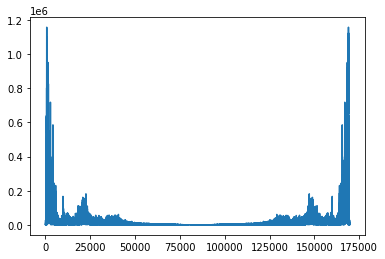

In [ ]:
i = 2 # woman dog
for maudio in masked_audios[i:i+1]:
  #fourier = maudio
  fourier = np.fft.fft(maudio)
  plt.plot(range(0, len(fourier)), np.abs(fourier))
  # magnitude of frequency response
  # fundamental freqs: m: 85-155 Hz, f: 165-255 Hz
  # so we should cut off at 255/22050

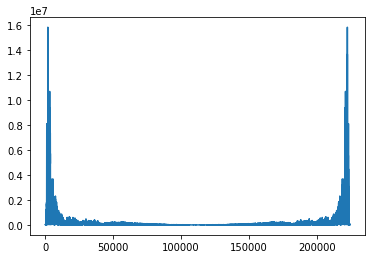

In [ ]:
i=4 # man kid
for maudio in masked_audios[i:i+1]:
  fourier = np.fft.fft(maudio)
  plt.plot(1*np.array(list(range(0, len(fourier)))), np.abs(fourier))

# Compute/extract mid-level input features

Note that we can actually ignore spectrum padding if we have audio padding, which is something we should do for wavelets anyway

In [ ]:
# restart here
# compute mel cepstrum with default params
# hanning, 2048 length fft, 512 a hop
fs = 48000/fctr
longest_spectrum = 0
wvlt_kind = 'db4'
wvlt_lvl = 2
mfcc_dim = 2

# feature arrays
#spectra = []
mf_ccs = []
#st_fts = []
spectral_f0s = []
spectral_contrasts = []
spectral_centroids = []
jit_ters = []
#spectral_rms = []
wvlts = []
smile_features = []


# download low level descriptor feature set from opensmile (25 features)
# then do feature selection on it later
'''
smile = opensmile.Smile(
  feature_set=opensmile.FeatureSet.eGeMAPSv02,
  feature_level=opensmile.FeatureLevel.Functionals,
)
'''

# acquire features
for masked_audio in masked_audios[:1]:

  
  # do EMD for hilbert spectrum
  imf = emd.sift.mask_sift(masked_audio, max_imfs=7)
  IP, IF, IA = emd.spectra.frequency_transform(imf, fs, 'nht')
  # can't find out how to get find hist bins from data to work to get log, so just let it run automatically
  f, spectrum = emd.spectra.hilberthuang(IF, IA, sample_rate=fs, edges=(1, 15000, 1000, 'log'), sum_time=False, return_sparse=True)
  # 512 = 16 * 32 = 8^3 = 4^6
  # for i in range(3):
  #   spectrum = scipy.signal.decimate(spectrum, 8)
  # edges=(1, 15000, 40, 'log')
  # and then librosa to go to log ig
  #mfcc = librosa.feature.mfcc(S=spectrum, sr=fs)
  mfcc = spectrum


  # it's time steps rows by features cols so we transpose it to timesteps cols by features rows
  #smile_features.append(smile.process_signal(masked_audio,fs).T)


  #print(len(masked_audio))

  # mel spectrogram
  # convert to log scale - ONLY IF USING MEL SPECTROGRAM, NOT MFCC
  #melSpec = librosa.feature.melspectrogram(masked_audio, sr=fs)
  #dbSpec = librosa.amplitude_to_db(melSpec)
  #print(dbSpec.shape)
  
  #spectra.append(dbSpec)
  
  # take wavelet transform, use a shift invariant wavelet, or test with db-4
  # dwt
  '''
  wvlt = np.array([])
  cA, cD = pywt.dwt(masked_audio, wvlt_kind, 'reflect')
  wvlt = np.concatenate((wvlt, cA, cD))
  wvlt = np.ndarray.flatten(librosa.feature.mfcc(wvlt, sr=fs)[:13])[None, :]'''

  # cwt
  #cA, cD = pywt.cwt(masked_audio, [1, 2, 4], wvlt_kind)
  #print(cA, cD)
  
  # multiscale analysis - let's concatenate all the coeffs, take mfcc, then take reg mfcc + mean + sd, not do mean sd for now

  # multiscale dwt - USE
  '''
  
  coeffs = pywt.wavedec(masked_audio, wvlt_kind, level=wvlt_lvl)

  wvlt = np.array([])
  for c in range(len(coeffs)):
    # multiscale analysis - take the mfcc
    #print(c, coeffs[c].shape)
    wvlt = np.concatenate((wvlt, coeffs[c]))
  
  #print(wvlt.shape)
  # add in regular mfcc, mean, sd
  reg_mfcc = librosa.feature.mfcc(masked_audio, sr=fs)
  #lpc = librosa.lpc(masked_audio, 16)
  #lpcc = librosa.feature.mfcc(lpc, sr=fs)

  
  # wlpcc_coeffs = pywt.wavedec(lpc, wvlt_kind, level=wvlt_lvl)

  # lpcc_wvlt = np.array([])
  # for c in range(len(wlpcc_coeffs)):
  #   # multiscale analysis - take the mfcc
  #   #print(c, coeffs[c].shape)
  #   lpcc_wvlt = np.concatenate((lpcc_wvlt, wlpcc_coeffs[c]))

  # wlpcc = librosa.feature.mfcc(lpcc_wvlt, sr=fs)

  # #print(mfcc.shape, reg_mfcc.shape, np.mean(reg_mfcc).shape, np.std(reg_mfcc.shape))
  # mfcc = wlpcc

  mfcc = librosa.feature.mfcc(wvlt, sr=fs)
  mfcc = np.hstack((mfcc, reg_mfcc))#, lpcc))
  '''
  mf_ccs.append(mfcc)



  # mfcc = already log of melspectrogram
  # get mfccs
  
  # mfcc = librosa.feature.mfcc(masked_audio, sr=fs)  
  # mfcc = np.array([np.hstack((np.array([np.mean(i) for i in mfcc]), np.array([np.std(i) for i in mfcc])))])

  '''
  # lowest spectral band in signal
  f0 = librosa.feature.spectral_rolloff(masked_audio, sr=fs, roll_percent=0.01)
  #spectral_f0s.append(f0)
  #print(wvlt.shape, f0[0].shape)
  mfcc = np.hstack((wvlt, *pywt.dwt(f0, wvlt_kind, 'reflect')))

  # just keep the audio
  #mfcc = np.array([masked_audio])'''
  #mf_ccs.append(mfcc)

  #longest_spectrum = max(longest_spectrum, mfcc.shape[1]) # can use this for stft too since same windowing

  # if just audio use this
  #longest_spectrum = max(longest_spectrum, mfcc.shape[1])

'''
#print(longest_spectrum)
#print(dbSpec.shape)
#cepstrum = np.array([])
mfccs = np.array([])
#stfts = np.array([])

#print(cepstrum.shape)'''
#print(longest_spectrum)
#print(len(local_jitter))
#print(f)

In [ ]:
pywt.wavelist(kind='discrete')

Unroll MFCCs

(20, 253053)
(20, 253053)


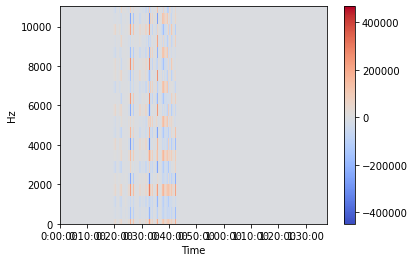

In [ ]:
mfccs = np.array([])
do = -0 # plot spectrogram/cepstrum of the nth clip where do = -n

# we have n spectra
for mfcc in mf_ccs:
  #print(mfcc)

  #print("pre-pad", mfcc.shape)
  # pad for time

  if mfcc.shape[1] < longest_spectrum:
    mfcc = np.pad(mfcc, ((0, 0), (0, longest_spectrum-mfcc.shape[1])), 'constant', constant_values=(0,0))
  #print("post-pad", mfcc.shape)

  # just plotting stuff
  
  if do < 0:
    do += 1
  elif do == 0:
    #print(spectrum.shape)
    print(mfcc.shape)
    cep = librosa.display.specshow(mfcc, x_axis="time", y_axis="linear")
    plt.colorbar(cep)
    do += 1

  # flatten the spectrogram
  if mfcc_dim == 1:
    mfcc = np.ndarray.flatten(mfcc, order='C')
    # add it with all the other spectrograms
    mfccs = np.hstack((mfccs, mfcc))
  elif mfcc_dim == 2:
    mfccs = np.vstack((mfccs, mfcc)) if mfccs.size else mfcc

  #mfccs = np.concatenate((mfccs, mfcc[0]))

print(mfccs.shape)


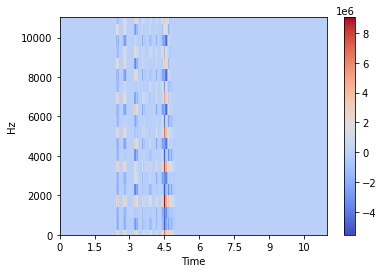

In [ ]:
# plotting
cep = librosa.display.specshow(mf_ccs[0], x_axis="time", y_axis="linear")
plt.colorbar(cep)

In [ ]:
a = np.array([[1,2,3, 4], [1,2,3,4], [1,2,3,4]])
b = np.array([[2,3,4,4], [3,4,5,4], [4,5,6,4]])
c = np.vstack((np.array([]), a, b))
print(c)
d = np.reshape(c, (2, -1, 4))
print(d)

##Unroll and plot 1d features

(1, 6937)
(23412375,)


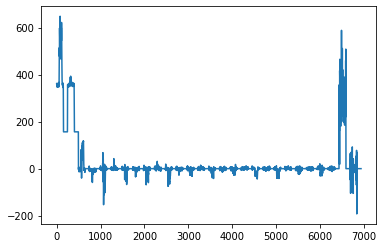

In [ ]:
mfccs = np.array([])
do = -2 # plot spectrogram/cepstrum of the nth clip where do = -n

# we have n spectra
for f0 in mf_ccs:

  #print("pre-pad", mfcc.shape)
  # pad for time
  if f0.shape[1] < longest_spectrum:
    f0 = np.pad(f0, ((0, 0), (0, longest_spectrum-f0.shape[1])), 'constant', constant_values=(0,0))
  #print("post-pad", mfcc.shape)

  # just plotting stuff
  if do < 0:
    do += 1
  elif do == 0:
    #print(spectrum.shape)
    print(f0.shape)
    plt.plot(range(f0.shape[1]), f0[0])
    do += 1

  # flatten the spectrogram
  f0_unroll = np.ndarray.flatten(f0, order='C')
  #print(mfcc_unroll.shape)

  # add it with all the other spectrograms
  mfccs = np.concatenate((mfccs, f0_unroll))

print(mfccs.shape)


##Unroll Spectrograms

(118080000,)


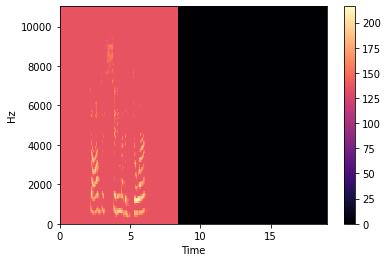

In [ ]:
do = -2 # plot spectrogram/cepstrum of the nth clip where do = -n

# we have n spectra
for spectrum in spectra:

  #print(spectrum)
  # normalise by subtracting minimum - it's log so we're just dividing everything by the same number and then pad 0
  #spectrum = spectrum - np.amin(spectrum) # only for cepstrum and not mfcc? those are actual multipliers i think
  # ACTUALLY DONT DO THIS EVEN IF PIC LOOKS UGLY -- UR ADDING FREQS THAT ARENT THERE -- 0PAD MEANS THERES NOTHING AFTER WHICH IS FINE
  #print(np.amin(spectrum))

  # pad
  if spectrum.shape[1] < longest_spectrum:
    spectrum = np.pad(spectrum, ((0, 0), (0, longest_spectrum-spectrum.shape[1])), 'constant', constant_values=(0,0))

  # thresholding
  '''
  for a in range(len(spectrum)):
    for b in range(len(spectrum[a])):
      if spectrum[a][b]<10: spectrum[a][b]=0 '''

  # just plotting stuff
  if do < 0:
    do += 1
  elif do == 0:
    #print(spectrum.shape)
    cep = librosa.display.specshow(spectrum, x_axis="time", y_axis="linear")
    plt.colorbar(cep)
    do += 1

  # flatten the spectrogram
  dbSpec_unroll = np.ndarray.flatten(spectrum, order='C')
  #print(dbSpec_unroll.shape)

  # add it with all the other spectrograms
  cepstrum = np.concatenate((cepstrum, dbSpec_unroll))

print(cepstrum.shape)

#cepstrum = np.reshape(n, cepstrum.shape[0]//n)
#cepstrum = np.asarray(cepstrum)
  #cep = librosa.display.specshow(dbSpec, x_axis="time", y_axis="linear")
  #plt.colorbar(cep)
  ##plt.imshow(dbSpec)

Unroll STFTs

In [ ]:
do = -2 # plot spectrogram/cepstrum of the nth clip where do = -n

# we have n spectra
for stft in st_fts:

  # pad
  if stft.shape[1] < longest_spectrum:
    stft = np.pad(stft, ((0, 0), (0, longest_spectrum-stft.shape[1])), 'constant', constant_values=(0,0))

  # thresholding
  '''
  for a in range(len(stft)):
    for b in range(len(stft[a])):
      if stft[a][b]<10: stft[a][b]=0 '''

  # just plotting stuff
  if do < 0:
    do += 1
  elif do == 0:
    #print(stft.shape)
    cep = librosa.display.specshow(stft, x_axis="time", y_axis="linear")
    plt.colorbar(cep)
    do += 1

  # flatten the spectrogram
  stft_unroll = np.ndarray.flatten(stft, order='C')
  #print(dbSpec_unroll.shape)

  # add it with all the other spectrograms
  stfts = np.concatenate((stfts, dbSpec_unroll))

print(stfts.shape)


In [ ]:
# TEST CELL
#import numpy as np
a = np.array([[1,2,3], [4,5,6]])
b = np.ones((2, 3))
print(a+b)
print(np.concatenate((a, b), axis=1))
# concatenate default is axis 0 which is vertical (make more data pts)
# axis 1 is adding horizontal (to each data pt)

[[2. 3. 4.]
 [5. 6. 7.]]
[[1. 2. 3. 1. 1. 1.]
 [4. 5. 6. 1. 1. 1.]]


In [ ]:
!pwd
%cd ../..

/content/data/data
/content


In [ ]:
%cd data/data

/content/data/data


## Smile feature saving

In [ ]:
# save smile_features
smile_features = torch.tensor(np.array(smile_features))
print(smile_features.shape)
torch.save(smile_features, "smile_features.pt")

torch.Size([3375, 25, 523])


In [ ]:
# load smile_features
loaded_smile_features = torch.load("smile_features.pt")
print(loaded_smile_features.shape)

torch.Size([3375, 25, 523])


# Form data matrices (let the model concat them)

In [ ]:
# stack everything into 1 mat called mfcc_mat (just because we started with mfcc and i don't wanna change name convention)

In [ ]:
# form data mat nxp where each row is unrolled features - maybe not needed for CNNs

#print(cepstrum.shape)

#cepstrum_mat = np.reshape(cepstrum, (n, cepstrum.shape[0]//n))
if mfcc_dim == 1:
  mfcc_mat = np.reshape(mfccs, (n, mfccs.shape[0]//n)) # here shape 0 is length of unrolled
elif mfcc_dim == 2:
  mfcc_mat = np.reshape(mfccs, (n, mfccs.shape[0]//n, mfccs.shape[1])) # here shape 0 is # rows and shape 1 is # cols
#stft_mat = np.reshape(stfts, (n, stfts.shape[0]//n))

#print(cepstrum.shape)

In [ ]:
print(mfcc_mat.shape)

(4500, 20, 990)


# Form data mats for smile features for testing w/ SVM and corr

In [ ]:
print(smile_features[0].shape)

(88, 1)


In [ ]:
smile_matrices = [np.array([])]*smile_features[0].shape[0]

# form a data mat for each feature
for datapt in smile_features:
  datapt = datapt.to_numpy()
  #print(datapt.shape)
  for feature in range(datapt.shape[0]): # should be 25 of these
    # append feature as the next datapt into each feature in array of feature matrices
    # so we want a data mat for each feature, each with rows and dims
    smile_matrices[feature] = np.concatenate((smile_matrices[feature], datapt[feature]))


In [ ]:
# for each feature mat in smile matrices, shape it to datapts by dimension
for m in range(len(smile_matrices)):
  #print(smile_matrices[m].shape, m)
  smile_matrices[m] = np.reshape(smile_matrices[m], (len(smile_features), datapt.shape[1])) # if this doesnt work use numpy shape things

In [ ]:
print(len(smile_matrices))
print(np.array(smile_matrices).shape)
print(smile_matrices[0][0])

88
(88, 1125, 1)
[0.]


# Split data matrices based on gender

In [ ]:
# start with mfcc_mat
male_mfcc_mat = np.array([])
female_mfcc_mat = np.array([])
mcount = 0
fcount = 0

for pt_ind in range(mfcc_mat.shape[0]):
  #print(gender_train_labels[nums[pt_ind][:-3]][int(nums[pt_ind][-3:])])
  # check for gender - labels first, classifier later
  if gender_train_labels[nums[pt_ind][:-3]][int(nums[pt_ind][-3:])] == 0: # female
    female_mfcc_mat = np.concatenate((female_mfcc_mat, mfcc_mat[pt_ind]))
    fcount += 1
  elif gender_train_labels[nums[pt_ind][:-3]][int(nums[pt_ind][-3:])] == 1: # male
    male_mfcc_mat = np.concatenate((male_mfcc_mat, mfcc_mat[pt_ind]))
    mcount += 1

print(male_mfcc_mat.shape, female_mfcc_mat.shape)

(16721100,) (16691400,)


In [ ]:
male_mfcc_mat = np.reshape(male_mfcc_mat, (mcount, male_mfcc_mat.shape[0]//mcount))
female_mfcc_mat = np.reshape(female_mfcc_mat, (fcount, female_mfcc_mat.shape[0]//fcount))

# Split labels based on gender

In [ ]:
print(nums)
print(emo_labels)

['sad114', 'sad114', 'sad114', 'sad104', 'sad104', 'sad104', 'neutral025', 'neutral025', 'neutral025', 'angry000', 'angry000', 'angry000', 'calm047', 'calm047', 'calm047', 'disgust086', 'disgust086', 'disgust086', 'fearful024', 'fearful024', 'fearful024', 'disgust018', 'disgust018', 'disgust018', 'neutral045', 'neutral045', 'neutral045', 'calm111', 'calm111', 'calm111', 'sad130', 'sad130', 'sad130', 'sad021', 'sad021', 'sad021', 'calm077', 'calm077', 'calm077', 'surprised105', 'surprised105', 'surprised105', 'calm033', 'calm033', 'calm033', 'happy049', 'happy049', 'happy049', 'happy021', 'happy021', 'happy021', 'happy039', 'happy039', 'happy039', 'happy080', 'happy080', 'happy080', 'sad084', 'sad084', 'sad084', 'fearful087', 'fearful087', 'fearful087', 'surprised012', 'surprised012', 'surprised012', 'disgust116', 'disgust116', 'disgust116', 'disgust096', 'disgust096', 'disgust096', 'sad092', 'sad092', 'sad092', 'fearful102', 'fearful102', 'fearful102', 'disgust146', 'disgust146', 'disg

In [ ]:
nums_m = []
nums_f = []

emo_labels_m = []
emo_labels_f = []

# this operation keeps label/clip order
for pt_ind in range(len(nums)):
  if gender_train_labels[nums[pt_ind][:-3]][int(nums[pt_ind][-3:])] == 0: # female
    nums_f.append(nums[pt_ind])
    emo_labels_f.append(emo_labels[pt_ind])
  elif gender_train_labels[nums[pt_ind][:-3]][int(nums[pt_ind][-3:])] == 1: # male
    nums_m.append(nums[pt_ind])
    emo_labels_m.append(emo_labels[pt_ind])

# Load up test audio

(too late now but note: pad the audio instead of the spectrum still - that's why it's kinda bad)

**TESTING DATA ON MODEL**

In [ ]:
%cd ../../test/test

/content/test/test


In [ ]:
# first we want to get a model that does this: run spectrogram -> pca -> kmeans to unsupervisedly find gender
testaudiolist = []
testnums = []

# iterate through all file
testpoints = -1
testcnt = 0
for file in os.listdir():
  if testcnt == testpoints and testpoints != -1:
    break
  # Check whether file is in text format or not
  if file.endswith(".wav"):
    if 'sample' not in file:
      # grab the emotion
      class_lbl = label_conversion.index(file[:-7])
      # one-hot encoding
      onehot_emo_labels.append([0]*class_lbl+[1]+[0]*(8-class_lbl-1))
      # no one-hot
      emo_labels.append(class_lbl)
    # print(1)
    # sample = 6 so for this case it's 6
    testnums.append(file[:-4]) # goes to emotion + num (removes .wav)
    fs, audiofile = wavfile.read(file)
    #f, t, Sxx = signal.spectrogram(x, fs)
    #audiofft = np.fft.fft(audiofile)
    # add audio as-is to array
    testaudiolist.append(audiofile)#fft)
    testcnt += 1
if testpoints == -1: testpoints = testcnt

<ipython-input-23-3038621423ed>:23: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, audiofile = wavfile.read(file)


In [ ]:
# for data augmentation

#audiolist = testaudiolist
# vis audio waveform
testaudios = []
for i in range (0, testpoints):
#i=13
  #shifted_audio = shift(audiolist[i])
  #noisy_audio = noise(audiolist[i])
  og_audio = testaudiolist[i]
  #noisy_shifted_audio = noise(shift(audiolist[i]))
  #audios.append(shifted_audio)
  #audios.append(noisy_audio)
  testaudios.append(og(np.array(og_audio, dtype=np.float64)))
  #audios.append(noisy_shifted_audio)
  #print(i, np.abs(audios[i][0]), audios[i])
  #plt.plot(range(0, len(audios[i])), audios[i])

# depends on the # of data augs
testn = 1*testpoints

In [ ]:
thresh = -0.01 # to be messed with - negative means no thresholding
print(testn)
# chop sound clip to parts with actual sound - keep structure but will have to pad later
test_masked_audios = []
for audio in testaudios[:testn]:
  masked_audio = np.asarray(chop_mask(audio, thresh), dtype=np.float64)
  test_masked_audios.append(masked_audio)
  # plot soundwaves
  #plt.plot(range(0, len(masked_audio)), masked_audio)

315


In [ ]:
# pad audio to max length (optional unless doing non-librosa fft analysis) - probably needed since wavelets not shift invar
# ig also assumes that train clips longer than test clips

for i in range(len(test_masked_audios)):
  if test_masked_audios[i].shape[0] < longest_aud:
    test_masked_audios[i] = np.pad(test_masked_audios[i], ((0, longest_aud-test_masked_audios[i].shape[0])), 'constant', constant_values=(0,0))

In [ ]:
longest_spectrum

0

# Test audio low/mid-level features

In [ ]:
'''
# test cell
p = [1, 3, 4, 6]
q = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
print([q[i] for i in p])'''

[1, 3, 4, 6]


In [ ]:
# restart here
# compute mel cepstrum with default params
# hanning, 2048 length fft, 512 a hop

#longest_spectrum = 0

# feature arrays
test_spectra = []
test_mf_ccs = []
test_st_fts = []
test_f0s = []
test_smile_features = []

fs = 48000

'''
smile = opensmile.Smile(
  feature_set=opensmile.FeatureSet.eGeMAPSv02,
  feature_level=opensmile.FeatureLevel.LowLevelDescriptors,
)'''

# acquire features
for masked_audio in test_masked_audios:
  
  # mel spectrogram
  # convert to log scale - ONLY IF USING MEL SPECTROGRAM, NOT MFCC
  #melSpec = librosa.feature.melspectrogram(masked_audio, sr=fs)
  #dbSpec = librosa.amplitude_to_db(melSpec)
  #print(dbSpec.shape)
  # if it is we figure something out - maybe just chop the signal because i'm tired and cant predict test data anyway
  #test_spectra.append(dbSpec)

  # mfcc = already log of melspectrogram
  # get mfccs
  #mfcc = librosa.feature.mfcc(masked_audio, sr=fs)
  #test_mf_ccs.append(mfcc)
  #test_smile_features.append(smile.process_signal(masked_audio,fs).T)

  
  # take wavelet transform, use a shift invariant wavelet, or test with db-4
  #wvlt = np.array([])
  #cA, cD = pywt.dwt(masked_audio, wvlt_kind, 'reflect')

  '''
  # cwt
  cA, cD = pywt.cwt(masked_audio, [1, 2, 4], wvlt_kind)
  #print(cA, cD)
  wvlt = np.concatenate((np.abs(cA[0]), np.abs(cA[1]), np.abs(cA[2])))
  # wavelet mfccs - not sure if this is the way but we can try
  '''
  
  '''
  wvlt = np.array([])
  cA, cD = pywt.dwt(masked_audio, wvlt_kind, 'reflect')
  mfcc = np.hstack((wvlt, cA, cD))'''
  #wvlt = np.ndarray.flatten(librosa.feature.mfcc(wvlt, sr=fs)[:13])[None, :]

  #test_mf_ccs.append(mfcc)


  # DO THIS GOOD
  
  wvlt = np.array([])

  coeffs = pywt.wavedec(masked_audio, wvlt_kind, level=wvlt_lvl)
  for c in range(len(coeffs)):
    # multiscale analysis - take the mfcc
    #print(c, coeffs[c].shape)
    wvlt = np.concatenate((wvlt, coeffs[c]))
  
  #print(wvlt.shape)
  # add in regular mfcc, mean, sd
  reg_mfcc = librosa.feature.mfcc(masked_audio, sr=fs)
  


  #lpc = librosa.lpc(masked_audio, 16)
  
  #lpcc = librosa.feature.mfcc(lpc, sr=fs)
  '''

  wlpcc_coeffs = pywt.wavedec(lpc, wvlt_kind, level=wvlt_lvl)

  lpcc_wvlt = np.array([])
  for c in range(len(wlpcc_coeffs)):
    # multiscale analysis - take the mfcc
    #print(c, coeffs[c].shape)
    lpcc_wvlt = np.concatenate((lpcc_wvlt, wlpcc_coeffs[c]))

  wlpcc = librosa.feature.mfcc(lpcc_wvlt, sr=fs)'''

  mfcc = librosa.feature.mfcc(wvlt, sr=fs)
  #print(mfcc.shape, reg_mfcc.shape, np.mean(reg_mfcc).shape, np.std(reg_mfcc.shape))
  mfcc = np.hstack((mfcc, reg_mfcc))#, lpcc))
  #mfcc = wlpcc
  #mfcc = np.hstack((mfcc, lpcc))


  #mfcc = librosa.feature.mfcc(masked_audio, sr=fs)  
  #mfcc = np.array([np.hstack((np.array([np.mean(i) for i in mfcc]), np.array([np.std(i) for i in mfcc])))])

  # lowest spectral band in signal
  #f0 = librosa.feature.spectral_rolloff(masked_audio, sr=fs, roll_percent=0.01)
  #mfcc = np.hstack((wvlt, f0))
  #mfcc = np.hstack((wvlt, *pywt.dwt(f0, wvlt_kind, 'reflect')))

  # do EMD for hilbert spectrum
  '''
  imf = emd.sift.mask_sift(masked_audio, max_imfs=7)
  IP, IF, IA = emd.spectra.frequency_transform(imf, fs, 'nht')
  # can't find out how to get find hist bins from data to work to get log, so just let it run automatically
  f, spectrum = emd.spectra.hilberthuang(IF, IA, sample_rate=fs, edges=(1, 15000, 70, 'log'), sum_time=False, return_sparse=True)
  # 512 = 16 * 32 = 8^3 = 4^6
  for i in range(3):
    spectrum = scipy.signal.decimate(spectrum, 8)
  # edges=(1, 15000, 40, 'log')
  # and then librosa to go to log ig
  mfcc = librosa.feature.mfcc(S=spectrum, sr=fs)'''



  test_mf_ccs.append(mfcc)


  # stfts
  #stft = librosa.feature.stft(masked_audio, sr=fs)
  #test_st_fts.append(stft)

  # f0s
  #f0 = librosa.feature.spectral_rolloff(masked_audio, sr=fs, roll_percent=0.01)
  #test_f0s.append(f0)

#print(longest_spectrum)
#print(dbSpec.shape)
'''
test_cepstrum = np.array([])
test_mfccs = np.array([])
test_stfts = np.array([])
'''

#print(cepstrum.shape)

'\ntest_cepstrum = np.array([])\ntest_mfccs = np.array([])\ntest_stfts = np.array([])\n'

Unroll MFCCs

[[166.30103021 166.30103021 166.30103021 ... 128.95104993 128.95104993
  128.95104993]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 ...
 [  8.1315053    5.30363451   7.55664663 ...   0.           0.
    0.        ]
 [  8.94364212   7.60687543   3.14395918 ...   0.           0.
    0.        ]
 [  6.43885981   7.46443968   2.53757096 ...   0.           0.
    0.        ]] (6300, 990)


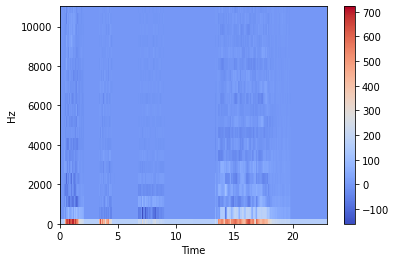

In [ ]:
do = -9 # plot spectrogram/cepstrum of the nth clip where do = -n
test_mfccs = np.array([])

# we have n spectra
for mfcc in test_mf_ccs:

  # try taking only first 13 mfcc's
  mfcc = mfcc

  # pad
  if mfcc.shape[1] < longest_spectrum:
    mfcc = np.pad(mfcc, ((0, 0), (0, longest_spectrum-mfcc.shape[1])), 'constant', constant_values=(0,0))

  # just plotting stuff
  if do < 0:
    do += 1
  elif do == 0:
    #print(spectrum.shape)
    cep = librosa.display.specshow(mfcc, x_axis="time", y_axis="linear")
    plt.colorbar(cep)
    do += 1

  # flatten the spectrogram
  if mfcc_dim == 1:
    mfcc = np.ndarray.flatten(mfcc, order='C')
    test_mfccs = np.hstack((test_mfccs, mfcc))
  elif mfcc_dim == 2:
    test_mfccs = np.vstack((test_mfccs, mfcc)) if test_mfccs.size else mfcc


print(test_mfccs, test_mfccs.shape)


##Unroll 1d features

In [ ]:
longest_spectrum

(1, 6937)
(2185155,)


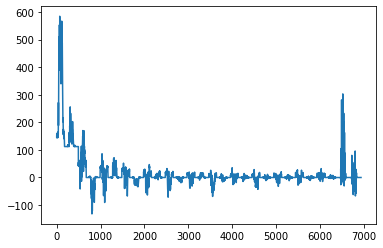

In [ ]:
test_mfccs = np.array([])
do = -2 # plot spectrogram/cepstrum of the nth clip where do = -n

# we have n spectra
for f0 in test_mf_ccs:

  #print("pre-pad", mfcc.shape)
  # pad for time
  if f0.shape[1] < longest_spectrum:
    f0 = np.pad(f0, ((0, 0), (0, longest_spectrum-f0.shape[1])), 'constant', constant_values=(0,0))
  #print("post-pad", mfcc.shape)

  # just plotting stuff
  if do < 0:
    do += 1
  elif do == 0:
    #print(spectrum.shape)
    print(f0.shape)
    plt.plot(range(f0.shape[1]), f0[0])
    do += 1

  # flatten the spectrogram
  f0_unroll = np.ndarray.flatten(f0, order='C')
  #print(mfcc_unroll.shape)

  # add it with all the other spectrograms
  test_mfccs = np.concatenate((test_mfccs, f0_unroll))

print(test_mfccs.shape)


###Unroll Spectrograms

In [ ]:
do = -2 # plot spectrogram/cepstrum of the nth clip where do = -n

# we have n spectra
for spectrum in test_spectra:

  #print(spectrum)
  # normalise by subtracting minimum - it's log so we're just dividing everything by the same number and then pad 0
  #spectrum = spectrum - np.amin(spectrum) # only for cepstrum and not mfcc? those are actual multipliers i think
  # ACTUALLY DONT DO THIS EVEN IF PIC LOOKS UGLY -- UR ADDING FREQS THAT ARENT THERE -- 0PAD MEANS THERES NOTHING AFTER WHICH IS FINE
  #print(np.amin(spectrum))

  # pad
  if spectrum.shape[1] < longest_spectrum:
    spectrum = np.pad(spectrum, ((0, 0), (0, longest_spectrum-spectrum.shape[1])), 'constant', constant_values=(0,0))

  # thresholding
  '''
  for a in range(len(spectrum)):
    for b in range(len(spectrum[a])):
      if spectrum[a][b]<10: spectrum[a][b]=0 '''

  # just plotting stuff
  if do < 0:
    do += 1
  elif do == 0:
    #print(spectrum.shape)
    cep = librosa.display.specshow(spectrum, x_axis="time", y_axis="linear")
    plt.colorbar(cep)
    do += 1

  # flatten the spectrogram
  dbSpec_unroll = np.ndarray.flatten(spectrum, order='C')
  #print(dbSpec_unroll.shape)

  # add it with all the other spectrograms
  test_cepstrum = np.concatenate((test_cepstrum, dbSpec_unroll))

print(test_cepstrum.shape)

#cepstrum = np.reshape(n, cepstrum.shape[0]//n)
#cepstrum = np.asarray(cepstrum)
  #cep = librosa.display.specshow(dbSpec, x_axis="time", y_axis="linear")
  #plt.colorbar(cep)
  ##plt.imshow(dbSpec)

NameError: ignored

Unroll STFTs

In [ ]:
do = -2 # plot spectrogram/cepstrum of the nth clip where do = -n

# we have n spectra
for stft in test_st_fts:

  # pad
  if stft.shape[1] < longest_spectrum:
    stft = np.pad(stft, ((0, 0), (0, longest_spectrum-stft.shape[1])), 'constant', constant_values=(0,0))

  # thresholding
  '''
  for a in range(len(stft)):
    for b in range(len(stft[a])):
      if stft[a][b]<10: stft[a][b]=0 '''

  # just plotting stuff
  if do < 0:
    do += 1
  elif do == 0:
    #print(stft.shape)
    cep = librosa.display.specshow(stft, x_axis="time", y_axis="linear")
    plt.colorbar(cep)
    do += 1

  # flatten the spectrogram
  stft_unroll = np.ndarray.flatten(stft, order='C')
  #print(dbSpec_unroll.shape)

  # add it with all the other spectrograms
  test_stfts = np.concatenate((test_stfts, dbSpec_unroll))

print(test_stfts.shape)


##Form data matrices to test (let the model concat them)

In [ ]:
# form data mat nxp where each row is unrolled features - maybe not needed for CNNs

#print(cepstrum.shape)

#test_cepstrum_mat = np.reshape(cepstrum, (n, cepstrum.shape[0]//n))
if mfcc_dim == 1:
  test_mfcc_mat = np.reshape(test_mfccs, (315, test_mfccs.shape[0]//315))
elif mfcc_dim == 2:
  test_mfcc_mat = np.reshape(test_mfccs, (315, test_mfccs.shape[0]//315, test_mfccs.shape[1]))
#test_stft_mat = np.reshape(stfts, (n, stfts.shape[0]//n))

#print(cepstrum.shape)

In [ ]:
print(test_mfcc_mat.shape)

(315, 20, 990)


In [ ]:
check_data = test_mfcc_mat
print(check_data)

[[[ 1.66301030e+02  1.66301030e+02  1.66301030e+02 ...  1.28951050e+02
    1.28951050e+02  1.28951050e+02]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  ...
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]]

 [[ 2.96565898e+02  2.95284156e+02  2.94959502e+02 ...  2.58219450e+02
    2.58219450e+02  2.58219450e+02]
  [ 8.09688446e+00  6.29963216e+00  5.84887208e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 7.94289686e+00  6.19098859e+00  5.76512046e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  ...
  [ 3.41689370e-01  7.2

In [ ]:
%cd ../..

/content


##Split test data by gender as well (gender detector comes in here)

In [ ]:
# start with mfcc_mat
male_test_mfcc_mat = np.array([])
female_test_mfcc_mat = np.array([])
test_mcount = 0
test_fcount = 0

for pt_ind in range(test_mfcc_mat.shape[0]):
  #print(gender_train_labels[nums[pt_ind][:-3]][int(nums[pt_ind][-3:])])
  # check for gender - labels first, classifier later
  if gender_check_labels[int(testnums[pt_ind][-3:])] == 0: # female
    female_test_mfcc_mat = np.concatenate((female_test_mfcc_mat, test_mfcc_mat[pt_ind]))
    test_fcount += 1
  elif gender_check_labels[int(testnums[pt_ind][-3:])] == 1: # male
    male_test_mfcc_mat = np.concatenate((male_test_mfcc_mat, test_mfcc_mat[pt_ind]))
    test_mcount += 1

print(male_test_mfcc_mat.shape, female_test_mfcc_mat.shape)

(1574100,) (1544400,)


In [ ]:
male_test_mfcc_mat = np.reshape(male_test_mfcc_mat, (test_mcount, male_test_mfcc_mat.shape[0]//test_mcount))
female_test_mfcc_mat = np.reshape(female_test_mfcc_mat, (test_fcount, female_test_mfcc_mat.shape[0]//test_fcount))

In [ ]:
print(male_test_mfcc_mat.shape, female_test_mfcc_mat.shape)

(159, 6435) (156, 6435)


In [ ]:
test_nums_m = []
test_nums_f = []

# this operation keeps label/clip order
for pt_ind in range(len(testnums)):
  if gender_check_labels[int(testnums[pt_ind][-3:])] == 0: # female
    test_nums_f.append(testnums[pt_ind])
  elif gender_check_labels[int(testnums[pt_ind][-3:])] == 1: # male
    test_nums_m.append(testnums[pt_ind])


In [ ]:
print(test_nums_m)
print(test_nums_f)

['sample228', 'sample017', 'sample077', 'sample162', 'sample046', 'sample107', 'sample286', 'sample023', 'sample040', 'sample118', 'sample246', 'sample057', 'sample007', 'sample235', 'sample291', 'sample126', 'sample072', 'sample292', 'sample166', 'sample083', 'sample030', 'sample188', 'sample026', 'sample157', 'sample172', 'sample091', 'sample084', 'sample293', 'sample197', 'sample237', 'sample098', 'sample190', 'sample280', 'sample013', 'sample209', 'sample245', 'sample247', 'sample073', 'sample062', 'sample075', 'sample179', 'sample060', 'sample150', 'sample019', 'sample227', 'sample034', 'sample108', 'sample174', 'sample140', 'sample033', 'sample249', 'sample255', 'sample131', 'sample260', 'sample133', 'sample310', 'sample009', 'sample287', 'sample231', 'sample008', 'sample142', 'sample196', 'sample305', 'sample173', 'sample006', 'sample103', 'sample298', 'sample164', 'sample176', 'sample051', 'sample289', 'sample049', 'sample192', 'sample177', 'sample283', 'sample014', 'sample148'

In [ ]:
%cd ../..

/content


In [ ]:
check_data_m = male_test_mfcc_mat
check_data_f = female_test_mfcc_mat

In [ ]:
print(check_data_m)

[[217.95378625 221.17841015 220.41202714 ...   0.           0.
    0.        ]
 [218.36638414 218.36638414 218.36638414 ...   0.           0.
    0.        ]
 [119.39134589 124.2695992  125.06414173 ...   0.           0.
    0.        ]
 ...
 [332.19393575 332.19393575 332.45133608 ...   0.           0.
    0.        ]
 [156.91954801 156.91954801 156.91954801 ...   0.           0.
    0.        ]
 [324.40467126 324.40467126 324.40467126 ...   0.           0.
    0.        ]]


# Viz

**After this point is viz! Can move onto inference implementation after KMeans and/or PCA**

In [ ]:
a = [1,2,3,4,5]
for b in a:
  b = 2*b

for c in a:
  print(c)

# references are not passed thru this way

1
2
3
4
5


In [ ]:
# what happens here why do colors and min value change (look above)

In [ ]:
def plot(i):
  ce = librosa.display.specshow(spectra[i], x_axis="time", y_axis="linear")
  plt.colorbar(ce)
# plot the ith clip
i= 0
plot(2)

IndexError: ignored

In [ ]:
print(spectra[6].shape)
print(spectra[6][-1][-1])

In [ ]:
plot(4)

In [ ]:
plot(3*i+3)

In [ ]:
print(cepstrum_mat[6][-1])

In [ ]:
j=2
plt.plot(range(len(cepstrum_mat[j])), cepstrum_mat[j])
print(cepstrum_mat[j])

In [ ]:
j=4
plt.plot(range(len(cepstrum_mat[j])), cepstrum_mat[j])

In [ ]:
for j in range (0, 15):
  plt.plot(range(len(cepstrum_mat[j])), cepstrum_mat[j])

In [ ]:
for j in range (280, 300):
  plt.plot(range(len(cepstrum_mat[j])), cepstrum_mat[j])

In [ ]:
# DONT RUN - condition number of data cov matrix XtX
#u, s, vh = np.linalg.svd(cepstrum_mat)

#print(np.amax(s)/np.amin(s))

# PCA

**PCA --> KMeans processing test**

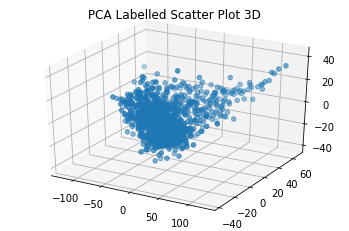

In [ ]:
# can also restart here
# sometimes PCA can be bad for accuracy? fewer features to look at even tho lower cond number

chosen_feature = mfcc_mat

dims = 3
if dims == 3:
  pca = PCA(n_components=3) # to be messed with
  # run PCA
  pca.fit(chosen_feature)
  pca_trans = pca.fit_transform(chosen_feature)
  #print(dbSpec[25][200])
  #print(pca_trans)
  fig = plt.figure()
  projplot = fig.add_subplot(111, projection='3d')
  projplot.scatter(pca_trans[:, 0], pca_trans[:, 1], pca_trans[:, 2])
  plt.title("PCA Labelled Scatter Plot 3D")
elif dims == 2:
  pca = PCA(n_components=2) # to be messed with
  # run PCA
  pca.fit(chosen_feature)
  pca_trans = pca.fit_transform(chosen_feature)
  #print(pca_trans)
  plt.scatter(pca_trans[:, 0], pca_trans[:, 1])
  plt.xlabel('Feature 1')
  plt.ylabel('Feature 2')
elif dims > 3:
  pca = PCA(n_components=dims) # to be messed with
  # run PCA
  pca.fit(chosen_feature)
  pca_trans = pca.fit_transform(chosen_feature)
  print(pca_trans)
plt.show()

In [ ]:
# pca train and test to feed into svm
check_data = pca_trans

In [ ]:
emo_data = pca_trans

In [ ]:
u, s_pca, vh = np.linalg.svd(pca_trans) # condition number of pca'd down data matrix

print(np.amax(s_pca)/np.amin(s_pca))

4.336749253745282


In [ ]:
#nums = [int(i) for i in nums]
print(nums)

['fearful024', 'fearful024', 'disgust048', 'disgust048', 'fearful089', 'fearful089', 'surprised147', 'surprised147', 'calm105', 'calm105', 'fearful081', 'fearful081', 'fearful091', 'fearful091', 'disgust030', 'disgust030', 'calm041', 'calm041', 'surprised084', 'surprised084', 'fearful059', 'fearful059', 'surprised044', 'surprised044', 'sad019', 'sad019', 'sad110', 'sad110', 'calm046', 'calm046', 'sad101', 'sad101', 'happy080', 'happy080', 'disgust067', 'disgust067', 'calm101', 'calm101', 'sad001', 'sad001', 'angry071', 'angry071', 'disgust037', 'disgust037', 'neutral039', 'neutral039', 'disgust025', 'disgust025', 'disgust078', 'disgust078', 'calm079', 'calm079', 'fearful060', 'fearful060', 'fearful125', 'fearful125', 'sad141', 'sad141', 'surprised018', 'surprised018', 'disgust109', 'disgust109', 'disgust146', 'disgust146', 'calm076', 'calm076', 'happy136', 'happy136', 'calm010', 'calm010', 'sad135', 'sad135', 'happy118', 'happy118', 'happy018', 'happy018', 'surprised009', 'surprised009

In [ ]:
g=zip([1, 2, 3, 4, 5], [2,3,4,5,6])
f = zip(list(range(2, 7)), g)
for a, (b, c) in f:
  print(a, b, c)

2 1 2
3 2 3
4 3 4
5 4 5
6 5 6


# Kmeans

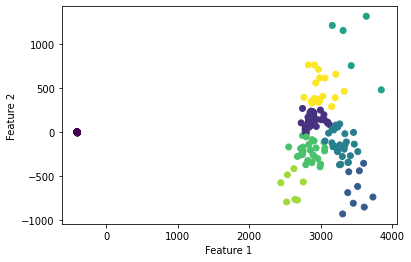

[0 0 0 ... 0 0 0]
1125


In [ ]:
# seed centroids with gender labels - doesnt work
# i'm lazy so before i hire 3rd world country kids let's just do k means anyway
# SKLearn implementation of kmeans
from sklearn.cluster import KMeans

K = 8

# can choose to use tsne like so: (comment if u dont want to tsne)
#pca_trans = np.array(embedding)
#dims = 3

kmeans = KMeans(#init=np.asarray([(pca_trans[0][0], pca_trans[0][1]), (pca_trans[1][0], pca_trans[1][1])]), 
                n_clusters=K, random_state=None, algorithm="full").fit(pca_trans)

# Replace each pixel with its nearest centroid, then plot the resulting image.
labels = kmeans.predict(pca_trans)
kmeans_flat = kmeans.cluster_centers_[labels]

# want to label each point with clip name
# so label each point with the order they show up in nums


if dims == 2:

  #plt.imshow(kmeans_flat.reshape(pca_trans.shape))

  # Plot pixels in 2D space, with each pixel having its quantized color.
  plt.scatter(pca_trans[:, 0], pca_trans[:, 1], c=labels)
  plt.xlabel('Feature 1')
  plt.ylabel('Feature 2')

  datapts = zip(pca_trans[:, 0], pca_trans[:, 1])
  datapts_labels = zip(nums, datapts)

  for num, (x,y) in datapts_labels:

      label = ""#num # whatever this point corresponds to

      plt.annotate(label, # this is the text
                  (x,y), # these are the coordinates to position the label
                  textcoords="offset points", # how to position the text
                  xytext=(0,10), # distance from text to points (x,y)
                  ha='center')
  plt.show()

elif dims == 3:
  #plt.imshow(kmeans_flat.reshape(pca_trans.shape))

  # Plot pixels in 2D space, with each pixel having its quantized color.
  fig = plt.figure()
  projplot = fig.add_subplot(111, projection='3d')
  projplot.scatter(pca_trans[:, 0], pca_trans[:, 1], pca_trans[:, 2], c= labels)
  plt.title("PCA Labelled Scatter Plot 3D")


print(labels)
print(len(labels))
# first 4 test: m f f m

In [ ]:
# to find a clip u find its ind in nums then put that to labels
# input total # of clips being run into range
'''
tempnumslist = [int(i[-3:]) for i in nums]
for a in range(len(tempnumslist)):
  print(a, labels[tempnumslist.index(a)])''' # this prints everything
  #if labels[nums.index(a)] == 0: # these 2 lines find points w/ particular class
    #print(a, labels[nums.index(a)])
    # first 4 sample: mffm, dddk
# FIX FOR TRAINING DATA USE AS WELL

'\ntempnumslist = [int(i[-3:]) for i in nums]\nfor a in range(len(tempnumslist)):\n  print(a, labels[tempnumslist.index(a)])'

# Fast TSNE

In [ ]:
!python3 -m pip install opentsne

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.7 MB 32.6 MB/s 


In [ ]:
from openTSNE import TSNE

For documentation and further usage here is link: https://github.com/huguyuehuhu/fastTSNE but now it's called openTSNE instead lmao


In [ ]:
tsne = TSNE(
	neighbors='approx',
	negative_gradient_method='fft'
)

embedding = tsne.fit(mfcc_mat)
embedding_test = tsne.fit(test_mfcc_mat)

NameError: ignored

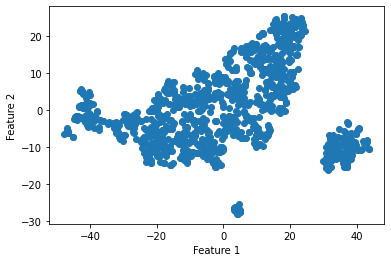

In [ ]:
plt.scatter(embedding[:, 0], embedding[:, 1])
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [ ]:
emo_data = embedding
check_data = embedding_test

NameError: ignored

# Load train/test split for tsne embeddings

In [ ]:
# after processing we can write dataloaders
# remember that data mat is the cepstrum matrix (for now)

tsne_data = np.array(embedding)


# train test split - since we test on separate data that's from the same set, we don't rly care about overfitting yah
train_data, test_data, train_labels, test_labels = train_test_split(tsne_data,
                                                                    emo_labels, train_size=0.9)#, random_state=np.random.RandomState())

print(tsne_data.shape, train_data.shape, test_data.shape)


(1125, 2) (1012, 2) (113, 2)


# Gender Classifier(ignore for now)

Go grab OtherMLP to use

In [ ]:
# let's not try with pure audio because too high dimensionality -- we want something simple for gender
# how about the first 13 cepstral coeffs again LOL

# then we dont need this cell because we load mfccs from above

# form data mat


'''
# form data matrix
gendermat = np.array([])

for maudio in masked_audios:

  gendermat = np.concatenate(())

gendermat = np.array(gendermat)
print(gendermat.shape)'''

(1125,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if __name__ == '__main__':


In [ ]:
print(nums)
print(longest_aud)
print(cepstrum.shape)

['disgust060', 'angry021', 'neutral052', 'fearful120', 'disgust126', 'disgust129', 'calm004', 'calm001', 'disgust006', 'happy057', 'neutral050', 'surprised102', 'calm084', 'neutral031', 'sad040', 'neutral006', 'angry018', 'disgust032', 'angry013', 'fearful066', 'happy066', 'disgust050', 'surprised078', 'disgust137', 'surprised148', 'surprised001', 'sad140', 'fearful094', 'disgust017', 'happy119', 'disgust023', 'angry115', 'happy046', 'disgust066', 'fearful100', 'angry097', 'fearful080', 'surprised129', 'happy098', 'angry137', 'happy045', 'calm100', 'calm036', 'disgust111', 'happy089', 'surprised122', 'sad077', 'calm086', 'neutral074', 'surprised098', 'happy072', 'happy110', 'sad056', 'happy134', 'calm060', 'sad134', 'sad145', 'happy022', 'surprised030', 'sad041', 'sad003', 'fearful012', 'calm059', 'angry127', 'calm101', 'neutral022', 'calm145', 'angry022', 'happy118', 'surprised037', 'disgust070', 'angry057', 'surprised104', 'sad111', 'neutral015', 'neutral000', 'surprised084', 'calm04

In [ ]:
# after processing we can write dataloaders
# remember that data mat is the cepstrum matrix (for now)

# grab train data and labels
train_gend_data = cepstrum

# process the labels to match the gender data since cepstrum follows nums order
train_gend_labels = [-1]*len(nums)
for i in range(len(nums)):
  i_name = nums[i][:-3]
  if i_name == 'fear': # correction
    i_name == 'fearful'
  # grab the category and number in that category in hashmap
  #print(i, i_name, nums[i])
  #print(gender_train_labels[i_name])
  train_gend_labels[i] = gender_train_labels[i_name][int(nums[i][-3:])]

# grab test data and labels
test_gend_data = test_cepstrum

# un-sort test labels to match data since og labels are sorted by number
test_gend_labels = [-1]*len(testnums)
for i in range(len(testnums)):
  #print(test_nums[i])
  test_gend_labels[i] = gender_check_labels[int(test_nums[i])]


print(train_gend_data.shape, test_gend_data.shape)


In [ ]:
# convert numpy ndarray format into tensors
train_ten, test_ten = torch.tensor(train_gend_data).cuda(), torch.tensor(test_gend_data).cuda()
train_y_ten, test_y_ten = torch.tensor(train_gend_labels).cuda(), torch.tensor(test_gend_labels).cuda()

# create datasets w/ torch tensor dataset loader
# from where u draw data
train_dataset = tdata.TensorDataset(train_ten, train_y_ten)
# dataloader
batch_size = 32
train_loader = tdata.DataLoader(train_dataset, batch_size=batch_size)

# Turn smile features into input

In [ ]:
print(smile.feature_names)
combo = [1, 3, 9, 16, 17]
combo= [6,7,8,9]
combo = list(range(88))

['F0semitoneFrom27.5Hz_sma3nz_amean', 'F0semitoneFrom27.5Hz_sma3nz_stddevNorm', 'F0semitoneFrom27.5Hz_sma3nz_percentile20.0', 'F0semitoneFrom27.5Hz_sma3nz_percentile50.0', 'F0semitoneFrom27.5Hz_sma3nz_percentile80.0', 'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2', 'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope', 'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope', 'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope', 'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope', 'loudness_sma3_amean', 'loudness_sma3_stddevNorm', 'loudness_sma3_percentile20.0', 'loudness_sma3_percentile50.0', 'loudness_sma3_percentile80.0', 'loudness_sma3_pctlrange0-2', 'loudness_sma3_meanRisingSlope', 'loudness_sma3_stddevRisingSlope', 'loudness_sma3_meanFallingSlope', 'loudness_sma3_stddevFallingSlope', 'spectralFlux_sma3_amean', 'spectralFlux_sma3_stddevNorm', 'mfcc1_sma3_amean', 'mfcc1_sma3_stddevNorm', 'mfcc2_sma3_amean', 'mfcc2_sma3_stddevNorm', 'mfcc3_sma3_amean', 'mfcc3_sma3_stddevNorm', 'mfcc4_sma3_amean', 'mfcc4_sma3_std

In [ ]:
mfcc_mat = np.hstack(smile_matrices[i] for i in combo)

<ipython-input-283-aa62f271c357>:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  mfcc_mat = np.hstack(smile_matrices[i] for i in combo)


In [ ]:
print(mfcc_mat.shape)

(1125, 88)


In [ ]:
mfcc_mat = np.hstack([np.vstack([
    np.ndarray.flatten(librosa.feature.mfcc(np.hstack(
          pywt.dwt(smile_matrices[i][j], 'db4', 'reflect'), # this is what u do for each datapt
          ), sr=fs))
    for j in range(len(smile_matrices[i]))]) for i in combo])

/usr/local/lib/python3.8/dist-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=530
  warnings.warn(


# Dataloaders for spectral input data

##Load from saved

In [ ]:
emo_data = torch.load('emo_data.pt')
emo_labels = torch.load('emo_labels.pt')
nums = list(np.load('nums.npy'))
testnums = list(np.load('testnums.npy'))
check_data = torch.load('check_data.pt')

In [ ]:
model = torch.load('semiglob_attn_hht_mfcc_55_epochs.pt')
starting_epoch = 55

##**Test MFCC/MelSpectrogram alone on NNs**

In [ ]:
print(mfcc_mat.shape)

(4500, 20, 990)


In [ ]:
# emergency code spot
#emo_labels = [float(l) for l in emo_labels]
#for i in range(len(emo_labels)):
  #emo_labels[i] = emo_labels[i][0]
  #emo_labels[i] = [float(j) for j in emo_labels[i]]
#emo_labels = emo_labels[:200]

In [ ]:
print(len(emo_labels))
print(onehot_emo_labels)
print(nums)
print(mfcc_mat)

4500
[[1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0], [0, 1, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 1, 0], [1, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 1, 0], [0, 0,

Note: label name abuse is getting confusing -- get rid soon

In [ ]:
# after processing we can write dataloaders
# remember that data mat is the cepstrum matrix (for now)

emo_data = mfcc_mat

In [ ]:
# train test split - since we test on separate data that's from the same set, we don't rly care about overfitting yah
train_data, test_data, train_labels, test_labels = train_test_split(emo_data,
                                                                    emo_labels, train_size=0.9)#, random_state=np.random.RandomState())

print(emo_data.shape, train_data.shape, test_data.shape)


(4500, 20, 990) (4050, 20, 990) (450, 20, 990)


In [ ]:
# convert numpy ndarray format into tensors
train_ten, test_ten = torch.tensor(train_data).cuda(), torch.tensor(test_data).cuda()
train_y_ten, test_y_ten = torch.tensor(train_labels).cuda(), torch.tensor(test_labels).cuda()

# create datasets w/ torch tensor dataset loader
# from where u draw data
train_dataset = tdata.TensorDataset(train_ten, train_y_ten)
# dataloader
batch_size = 4
train_loader = tdata.DataLoader(train_dataset, batch_size=batch_size)

This block of code down here works only specifically for MLPs

In [ ]:
check_data = test_mfcc_mat
'''print(train_y_ten.shape)
print(test_ten.shape)
print(test_y_ten)'''

'print(train_y_ten.shape)\nprint(test_ten.shape)\nprint(test_y_ten)'

# Dataloaders for gendered spectral input data

**Test MFCC/MelSpectrogram alone on NNs**

In [ ]:
print(male_mfcc_mat.shape, female_mfcc_mat.shape)

NameError: ignored

In [ ]:
# emergency code spot
#emo_labels = [float(l) for l in emo_labels]
#for i in range(len(emo_labels)):
  #emo_labels[i] = emo_labels[i][0]
  #emo_labels[i] = [float(j) for j in emo_labels[i]]
#emo_labels = emo_labels[:200]

In [ ]:
print(len(emo_labels))
print(onehot_emo_labels)
print(nums)

4500
[[1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0], [0, 1, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 1, 0], [1, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 1, 0], [0, 0,

Note: label name abuse is getting confusing -- get rid soon

In [ ]:
# after processing we can write dataloaders
# remember that data mat is the cepstrum matrix (for now)
train_size = .9

emo_data_m = male_mfcc_mat
emo_data_f = female_mfcc_mat


# train test split - since we test on separate data that's from the same set, we don't rly care about overfitting yah
train_data_m, test_data_m, train_labels_m, test_labels_m = train_test_split(emo_data_m,
                                                                            emo_labels_m, train_size=train_size, test_size=1-train_size)

print(emo_data_m.shape, train_data_m.shape, test_data_m.shape)


# train test split - since we test on separate data that's from the same set, we don't rly care about overfitting yah
train_data_f, test_data_f, train_labels_f, test_labels_f = train_test_split(emo_data_f,
                                                                            emo_labels_f, train_size=train_size, test_size=1-train_size)

print(emo_data_f.shape, train_data_f.shape, test_data_f.shape)


NameError: ignored

In [ ]:
# convert numpy ndarray format into tensors
train_ten_m, test_ten_m = torch.tensor(train_data_m).cuda(), torch.tensor(test_data_m).cuda()
train_y_ten_m, test_y_ten_m = torch.tensor(train_labels_m).cuda(), torch.tensor(test_labels_m).cuda()

# create datasets w/ torch tensor dataset loader
# from where u draw data
train_dataset_m = tdata.TensorDataset(train_ten_m, train_y_ten_m)
# dataloader
batch_size = 8
train_loader_m = tdata.DataLoader(train_dataset_m, batch_size=batch_size)

In [ ]:
# convert numpy ndarray format into tensors
train_ten_f, test_ten_f = torch.tensor(train_data_f).cuda(), torch.tensor(test_data_f).cuda()
train_y_ten_f, test_y_ten_f = torch.tensor(train_labels_f).cuda(), torch.tensor(test_labels_f).cuda()

# create datasets w/ torch tensor dataset loader
# from where u draw data
train_dataset_f = tdata.TensorDataset(train_ten_f, train_y_ten_f)
# dataloader
#batch_size = 32
train_loader_f = tdata.DataLoader(train_dataset_f, batch_size=batch_size)

This block of code down here works only specifically for MLPs

In [ ]:
print(train_y_ten_f.shape)
print(test_ten_f.shape)
print(test_y_ten_f.shape)

# K-fold cross validation (copy paste the training code)

Doing this in a separate method to not abuse/change existing variables, save ram, and have versatility for multiple datasets if needed.

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
# prepare cross_validation
def train_test_model_for_kfold(datapts_set, labels_set, n_splits=10, shuffle=True):
  # input: datapts and labels intact, this splits it for u
  # so datapts would be emo_data and labels would be emo_labels (make sure to run code that defines these)

  kfold = KFold(n_splits=n_splits, shuffle=shuffle)

  for train, test in kfold.split(datapts_set):
    train_data, test_data = datapts_set[train], datapts_set[test]
    train_labels, test_labels = labels_set[train], labels_set[test]

    # then convert to tensors and train the model. if it's an sklearn svm then just toss the thing in and run

    # dataloaders: if using pytorch, uncomment
    '''
    # convert numpy ndarray format into tensors
    train_ten, test_ten = torch.tensor(train_data).cuda(), torch.tensor(test_data).cuda()
    train_y_ten, test_y_ten = torch.tensor(train_labels).cuda(), torch.tensor(test_labels).cuda()

    # create datasets w/ torch tensor dataset loader
    # from where u draw data
    train_dataset = tdata.TensorDataset(train_ten, train_y_ten)
    # dataloader
    batch_size = 32
    train_loader = tdata.DataLoader(train_dataset, batch_size=batch_size)'''

    # put whatever training code u want in here so not messy
    train_method_kfold(train_loader, test_data, test_labels)

    # here u can put whatever interpretation/validation code u want (like classification report or conf mats)


def train_method_kfold(train_loader=None, test_data, test_labels):
  # whatever training code to copy paste
  return None

In [ ]:
# run cross val
train_test_model_for_kfold(emo_data, emo_labels)

Afterwards copy-paste the code for accuracy too and use it

#Define NN Models

##Set Mode MLPs

In [ ]:
class Gendered_MLP(torch.nn.Module): # just testing this before any pca - proven to work with half the data
  def __init__(self):
    super().__init__()

    # shape adjusts to the data since it's padded to fit the longest
    self.fc1 = torch.nn.Linear(in_features=emo_data.shape[1], out_features=2048)
    self.fc2 = torch.nn.Linear(in_features=2048, out_features=2048)
    self.fc6 = torch.nn.Linear(in_features=2048, out_features=2048)
    self.fc7 = torch.nn.Linear(in_features=2048, out_features=1024)
    self.fc8 = torch.nn.Linear(in_features=1024, out_features=256)
    self.fc9 = torch.nn.Linear(in_features=256, out_features=8)
    self.dropout = torch.nn.Dropout(p=0.2)
    #self.apply(self._init_weights)

  def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            module.weight.data.normal_(mean=0.0, std=1)
            if module.bias is not None:
                module.bias.data.zero_()

  def forward(self, input):
    # pass each nonlinearity into the other layer
    in_1 = torch.relu(self.fc1(input))
    in_2 = self.dropout(torch.relu(self.fc2(in_1)))
    in_6 = self.dropout(torch.relu(self.fc6(in_2)))
    in_7 = self.dropout(torch.relu(self.fc7(in_6)))
    in_8 = torch.relu(self.fc8(in_7))
    in_9 = self.fc9(in_8) # last layer is typically left linaer because it's going to be passed into nonlinearity anyway?
    #in_last = max(in_9.flatten())
    return torch.sigmoid(in_9) # pass sigmoid because binary classification - want both ends - try softmax
    # dont apply if regression because we dont believe that regression values between 0 and 1


In [ ]:
class Simplest_MLP(torch.nn.Module): # just testing this before any pca
  def __init__(self):
    super().__init__()

    # shape adjusts to the data since it's padded to fit the longest
    self.fc1 = torch.nn.Linear(in_features=emo_data.shape[1], out_features=50)
    #self.fc2 = torch.nn.Linear(in_features=2048, out_features=2048)
    self.fc6 = torch.nn.Linear(in_features=50, out_features=8)
    #self.apply(self._init_weights)

  def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            module.weight.data.normal_(mean=0.0, std=1)
            if module.bias is not None:
                module.bias.data.zero_()

  def forward(self, input):
    #print("forward", input.shape)
    # pass each nonlinearity into the other layer
    in_1 = torch.relu(self.fc1(input))
    in_2 = in_1#torch.relu(self.fc2(in_1))
    in_9 = self.fc6(in_2) # last layer is typically left linaer because it's going to be passed into nonlinearity anyway?
    #in_last = max(in_9.flatten())
    return torch.sigmoid(in_9) # pass sigmoid because binary classification - want both ends - try softmax
    # dont apply if regression because we dont believe that regression values between 0 and 1


In [ ]:
class Other_MLP(torch.nn.Module): # just testing this before any pca
  def __init__(self):
    super().__init__()

    # shape adjusts to the data since it's padded to fit the longest
    self.fc1 = torch.nn.Linear(in_features=emo_data.shape[1], out_features=2048)
    #self.fc2 = torch.nn.Linear(in_features=2048, out_features=2048)
    self.fc6 = torch.nn.Linear(in_features=2048, out_features=2048)
    self.fc7 = torch.nn.Linear(in_features=2048, out_features=1024)
    self.fc8 = torch.nn.Linear(in_features=1024, out_features=256)
    self.fc9 = torch.nn.Linear(in_features=256, out_features=8)
    #self.apply(self._init_weights)

  def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            module.weight.data.normal_(mean=0.0, std=1)
            if module.bias is not None:
                module.bias.data.zero_()

  def forward(self, input):
    #print("forward", input.shape)
    # pass each nonlinearity into the other layer
    in_1 = torch.relu(self.fc1(input))
    in_2 = in_1#torch.relu(self.fc2(in_1))
    in_6 = torch.relu(self.fc6(in_2))
    in_7 = torch.relu(self.fc7(in_6))# +in_1)) # didnt have res connection here at first, was trying it out but didnt rly help bad features converge
    in_8 = torch.relu(self.fc8(in_7))
    in_9 = self.fc9(in_8) # last layer is typically left linaer because it's going to be passed into nonlinearity anyway?
    #in_last = max(in_9.flatten())
    return torch.sigmoid(in_9) 


In [ ]:
class Wavelet_MLP_Acti(torch.nn.Module): # just testing this before any pca
  def __init__(self):
    super().__init__()

    # shape adjusts to the data since it's padded to fit the longest
    self.fc1 = torch.nn.Linear(in_features=emo_data.shape[1], out_features=2048)
    #self.fc2 = torch.nn.Linear(in_features=2048, out_features=2048)
    self.fc6 = torch.nn.Linear(in_features=2057, out_features=2048) 
    self.fc7 = torch.nn.Linear(in_features=2048, out_features=1024)
    self.fc8 = torch.nn.Linear(in_features=1024, out_features=256)
    self.fc9 = torch.nn.Linear(in_features=256, out_features=8)
    #self.apply(self._init_weights)

  def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            module.weight.data.normal_(mean=0.0, std=1)
            if module.bias is not None:
                module.bias.data.zero_()

  def forward(self, input):
    # pass each nonlinearity into the other layer
    #print(input.shape)
    with torch.no_grad():
      temp = np.array([[]]*input.shape[0])
      for i in pywt.wavedec(self.fc1(input).cpu().clone(), 'db2', level=4):
        #print(i.shape)
        temp = np.hstack((temp, i))
        #temp = torch.tensor(np.reshape(temp, (batch_size, temp.shape[0]//batch_size)))
      #print(np.array(temp).shape)
    in_2 = torch.tensor(temp).cuda()
    #in_2 = in_1#torch.relu(self.fc2(in_1))
    in_6 = torch.relu(self.fc6(in_2))
    in_7 = torch.relu(self.fc7(in_6))
    in_8 = torch.relu(self.fc8(in_7))
    in_9 = self.fc9(in_8) # last layer is typically left linaer because it's going to be passed into nonlinearity anyway?
    #in_last = max(in_9.flatten())
    return torch.sigmoid(in_9) # pass sigmoid because binary classification - want both ends - try softmax
    # dont apply if regression because we dont believe that regression values between 0 and 1


In [ ]:
class Multimodal_MLP(torch.nn.Module): 
  # split data based on modes - just crude chopping for now
  # but we can simply just save the indices of each feature and use that

  def __init__(self, n_modes=1):
    super().__init__()

    with torch.no_grad():
      self.features = []
      self.outputs = []
      self.n_modes = n_modes
      self.blocks = []

    self.fc10 = torch.nn.Linear(in_features=16*n_modes, out_features=8)
    #self.apply(self._init_weights)

  '''
  def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            module.weight.data.normal_(mean=0.0, std=1)
            if module.bias is not None:
                module.bias.data.zero_()
  '''

  def forward(self, input):

    # clear the array in case it stays
    
    with torch.no_grad():
      self.features = []
      self.outputs = []

    #print("forward", input.shape)

    # split the input data according to the # of modes, and in forward we apply the layers to each one separately, then combine later
    
    for i in range(self.n_modes):
      with torch.no_grad():
        self.features.append(input[:, input.shape[1]//self.n_modes*i:input.shape[1]//self.n_modes*(i+1)])
        #print("segment", input.shape[1]//self.n_modes*i, input.shape[1]//self.n_modes*(i+1))
      # create a block for each feature
      self.blocks.append(Multimodal_MLP_Block(n_modes=self.n_modes).double().cuda())

    # pass all the features into each block separately
    for ft_ind in range(len(self.features)):

      temp_result = self.blocks[ft_ind](self.features[ft_ind])
      #print("input of block", self.features[ft_ind].shape)
      #print("output of block", temp_result.shape)
      self.outputs.append(temp_result)
      del temp_result

    

    # here we stack all the things in the outputs together
    with torch.no_grad():
      new_tensor = torch.tensor([[]]*input.shape[0]).cuda()
      for output in self.outputs:
        #print("output", output.shape)
        new_tensor = torch.hstack((new_tensor, output))
        del output
        #print("new tensor", new_tensor.shape)


    #print()
    #print()

    return torch.sigmoid(self.fc10(new_tensor))
    # pass sigmoid because binary classification - want both ends - try softmax
    # dont apply if regression because we dont believe that regression values between 0 and 1


In [ ]:
class Multimodal_MLP_Block(torch.nn.Module):
  def __init__(self, n_modes=1):
    super().__init__()

    # shape adjusts to the data since it's padded to fit the longest
    self.fc1 = torch.nn.Linear(in_features=emo_data.shape[1]//n_modes, out_features=2048)
    #self.fc2 = torch.nn.Linear(in_features=2048, out_features=2048)
    self.fc6 = torch.nn.Linear(in_features=2048, out_features=2048)
    self.fc7 = torch.nn.Linear(in_features=2048, out_features=1024)
    self.fc8 = torch.nn.Linear(in_features=1024, out_features=100)
    self.fc9 = torch.nn.Linear(in_features=100, out_features=16)
    #self.apply(self._init_weights)

  def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            module.weight.data.normal_(mean=0.0, std=1)
            if module.bias is not None:
                module.bias.data.zero_()

  def forward(self, input):
    # pass each nonlinearity into the other layer
    in_1 = torch.relu(self.fc1(input))
    in_2 = in_1#torch.relu(self.fc2(in_1))
    in_6 = torch.relu(self.fc6(in_2))
    in_7 = torch.relu(self.fc7(in_6 + in_1))
    in_8 = torch.relu(self.fc8(in_7))
    in_9 = self.fc9(in_8) # last layer is typically left linaer because it's going to be passed into nonlinearity anyway?
    #in_last = max(in_9.flatten())
    return in_9

In [ ]:
class Multimodal_Together_MLP(torch.nn.Module): 
  # split data based on modes - just crude chopping for now
  # but we can simply just save the indices of each feature and use that
  # actually yea same length since we pad the audio

  def __init__(self, n_modes=3):
    super().__init__() # assume 3 modes for now

    with torch.no_grad():
      self.features = []
      self.n_modes = n_modes
      self.blocks = [Multimodal_MLP_Block(n_modes=self.n_modes).double().cuda() for i in range(n_modes)]

    '''
    self.fc11 = torch.nn.Linear(in_features=emo_data.shape[1]//n_modes, out_features=self.lay_n)
    self.fc12 = torch.nn.Linear(in_features=self.lay_n, out_features=self.lay_n1)
    self.fc13 = torch.nn.Linear(in_features=self.lay_n1, out_features=self.lay_n1)
    self.fc13 = torch.nn.Linear(in_features=256, out_features=16)

    self.fc21 = torch.nn.Linear(in_features=emo_data.shape[1]//n_modes, out_features=self.lay_n)
    self.fc22 = torch.nn.Linear(in_features=self.lay_n, out_features=256)
    self.fc23 = torch.nn.Linear(in_features=256, out_features=16)

    self.fc31 = torch.nn.Linear(in_features=emo_data.shape[1]//n_modes, out_features=self.lay_n)
    self.fc32 = torch.nn.Linear(in_features=self.lay_n, out_features=256)
    self.fc33 = torch.nn.Linear(in_features=256, out_features=16)'''


    self.fc9 = torch.nn.Linear(in_features=16*n_modes, out_features=32)
    self.fc10 = torch.nn.Linear(in_features=32, out_features=8)
    #self.apply(self._init_weights)


  '''
  def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            module.weight.data.normal_(mean=0.0, std=1)
            if module.bias is not None:
                module.bias.data.zero_()
  
  def fwd1(self, input):
    input = torch.relu(self.fc111(input))
    input = torch.relu(self.fc12(input))
    input = torch.relu(self.fc13(input))
    return input

  def fwd2(self, input):
    input = torch.relu()
    return input

  def fwd3(self, input):
    input = torch.relu(self.fc31(input))
    input = torch.relu(self.fc32(input))
    input = torch.relu(self.fc33(input))
    return input
  '''

  def forward(self, input):

    # clear the array in case it stays
    
    with torch.no_grad():
      self.features = []

    #print("forward", input.shape)

    # split the input data according to the # of modes, and in forward we apply the layers to each one separately, then combine later
    for i in range(self.n_modes):
      self.features = [input[:, input.shape[1]//self.n_modes*i:input.shape[1]//self.n_modes*(i+1)] 
                       for i in range(self.n_modes)]

    # pass all the features into each block separately  

    #print()
    #print()

    return torch.sigmoid(self.fc10(torch.relu(self.fc9(torch.hstack([self.blocks[i](self.features[i])
     for i in range(len(self.blocks))]).cuda()))))


##When making multi-block MLPs try to spawn/access as few lists as possible

In [ ]:
class Wavelet_MLP_Block(torch.nn.Module):
  # handle the scales of each block

  def __init__(self, scales, resolution, input_len):
    #print(resolution, scales, input_len)
    # idea is that the higher the resolution the finer u need to look
    # so we multiply some base number by the reciprocal of resolution/scales
    super().__init__()
    self.factor = 2**(resolution-scales+1)
    # res is ind in the output, higher the ind the higher the res
    # at ind0, factor = 1. at ind n, factor = 2^(scales-n)

    # may need to check the input dimension for this one
    # 11 and 7 for the big numbers, for mean std use like 3 and 3
    self.kern = 1#min(max(1, math.ceil(3/resolution*scales)), input_len)
    self.conv1 = torch.nn.Conv1d(in_channels=1, out_channels=16*self.factor, 
                                 kernel_size= self.kern,
                                 stride=2)#max(1, 3//resolution*scales))
    # channels, filters, size, stride, padding
    self.bn1 = torch.nn.BatchNorm1d(16*self.factor)
    self.gap = torch.nn.AvgPool1d(16*self.factor)

    # shape adjusts to the data since it's padded to fit the longest
    self.fc1 = torch.nn.LazyLinear(out_features=2048)
    self.fc2 = torch.nn.Linear(in_features=2048, out_features=2048)
    self.fc3 = torch.nn.Linear(in_features=2048, out_features=1536)
    self.fclast = torch.nn.Linear(in_features=1536, out_features=256)
    self.dropout = torch.nn.Dropout(p=0.2)
    
    # want to add a small convolution -> bn -> pooling here and change kernel window based on scale

    #self.apply(self._init_weights)

  def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            module.weight.data.normal_(mean=0.0, std=1)
            if module.bias is not None:
                module.bias.data.zero_()

  def forward(self, input):
    # want to convert [batchsize, len] to [batchsize, 1, len]
    #inp_copy = input.clone()
    input = input[:, None, :]
    #print("b4 conv", input.shape)
    input = self.conv1(input)
    #print("after conv", input.shape)
    input = self.bn1(input)
    input = torch.reshape(input, (input.shape[0], input.shape[1]*input.shape[2]))
    input = torch.relu(input)# + inp_copy)
    inp_copy = input.clone()
    #input = self.gap(input)
    #print("after gap", input.shape)
    input = self.dropout(torch.relu(self.fc1(input)))
    input = self.dropout(torch.relu(self.fc2(input)))
    input = self.dropout(torch.relu(self.fc3(input)))
    input = torch.relu(self.fclast(input))
    return input


In [ ]:
class Feature_Block(torch.nn.Module):
  # handle the wavelet transform and split into scales here - take scales
  def __init__(self, scales=2, input_len=None):
    super().__init__()
    with torch.no_grad():
      # want to calculate input len per scale here
      # starting from 0, ith one has len 1/2 ^ (i+1) but last one has 1/2^n
      self.blocks = [Wavelet_MLP_Block(scales, reso+1,
                                       int(input_len*.5**(reso+1 if reso < scales else reso))).double().cuda()
                                        for reso in range(scales+1)]
      self.coeffs = []
      self.scales = scales

    self.fc1 = torch.nn.LazyLinear(out_features=32)


  def forward(self, input):
    # pass each nonlinearity into the other layer
    #print(input.shape)
    with torch.no_grad():

      self.coeffs = [torch.tensor(i).cuda() for i in pywt.wavedec(input.cpu(), 'db2', level=self.scales)]

      output = torch.relu(self.fc1(torch.hstack(
          [self.blocks[i](self.coeffs[i]) for i in range(len(self.coeffs))])))
      
      #print(output.shape)
      return output


In [ ]:
class Wavelet_Block(torch.nn.Module):
  # handle the wavelet transform and split into scales here - take scales
  def __init__(self, scales=2, input_len=None):
    super().__init__()
    with torch.no_grad():
      self.scales = scales

    self.conv1 = torch.nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3,stride=2)
    # channels, filters, size, stride, padding
    self.bn1 = torch.nn.BatchNorm1d(64)
    self.conv2 = torch.nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3,stride=1)
    self.bn2 = torch.nn.BatchNorm1d(64)
    #self.convlast = torch.nn.Conv1d(in_channels=64, out_channels=1, kernel_size=1, stride=1)
    self.mapool = torch.nn.MaxPool1d(3, stride=1)
    self.gap = torch.nn.AvgPool1d(64)

    # shape adjusts to the data since it's padded to fit the longest
    self.fc1 = torch.nn.LazyLinear(out_features=256)
    self.fc4 = torch.nn.Linear(in_features=512, out_features=512)
    self.fclast = torch.nn.Linear(in_features=512, out_features=256)
    self.dropout = torch.nn.Dropout(p=0.2)


  def forward(self, input):
    # pass each nonlinearity into the other layer
    #print(input.shape)
    #with torch.no_grad():

    #  input = torch.hstack([torch.tensor(i).cuda() for i in pywt.wavedec(input.cpu(), 'db4', level=self.scales)])

    #print("after dwt", input.shape)
    input = input[:, None, :]
    #print("b4 conv", input.shape)
    input = self.conv1(input)
    #print("after conv", input.shape)
    input = self.bn1(input)
    input = self.mapool(input)
    inp_copy = input.clone()
    input = torch.relu(input)
    input = self.conv2(input)
    with torch.no_grad():
      inp_copy = torch.tensor(np.pad(inp_copy.cpu(), ((0,0),(0,0)
      ,(0, input.shape[2]-inp_copy.shape[2] if input.shape[2]-inp_copy.shape[2] > 0 else 0)))).cuda()
      input = torch.tensor(np.pad(input.cpu(), ((0,0),(0,0)
      ,(0, inp_copy.shape[2]-input.shape[2] if inp_copy.shape[2]-input.shape[2] > 0 else 0)))).cuda()

    input = torch.relu(self.bn2(input + inp_copy))

    #input = self.convlast(input + inp_copy)
    input = self.gap(input)

    input = torch.reshape(input, (input.shape[0], input.shape[1]*input.shape[2]))
    # with torch.no_grad():
    #   down_factor = int(math.ceil(input.shape[1]/inp_copy.shape[1]))
    #   downsampled = np.pad(scipy.signal.decimate(input.cpu(), down_factor),
    #                           ((0, 0), (0, input.shape[1]%down_factor+1)))
    #   #print(downsampled.shape, inp_copy.shape)
    #   temp_tens = torch.tensor(downsampled).cuda() + inp_copy
    # input = torch.relu(temp_tens)
    #inp_copy = input.clone()
    #print("after gap", input.shape)
    #input = torch.relu(input)
    input = torch.relu(self.fc1(input))
    # input = torch.relu(self.fc4(input))
    # input = torch.relu(self.fclast(input))
    return input


In [ ]:
class Wavelet_Smile_MLP(torch.nn.Module):
  # input will be concatenation of a bunch of 1d signals (same length since we pad audio)
  # since we know this, we can take the chop places as input

  def __init__(self, chops=[0, -1], scales=2): 
    # -1 here represents the last index: note that -1 doesnt actually work, u have to put last ind
    # default is no chopping, #blocks = scales+1 b/c 2 splits gives 3 arrays
    # keep in mind that each scale will have half of previous scale, until last 2 scales are the same
    super().__init__()

    with torch.no_grad():
      self.features = []
      #self.blocks = [Feature_Block(scales=scales, input_len=chops[c+1]-chops[c]).double().cuda() for c in range(len(chops)-1)]
      self.blocks = [Wavelet_Block(scales=scales, input_len=chops[c+1]-chops[c]).double().cuda() for c in range(len(chops)-1)]
      self.chops = chops
  
    # we will be GAPping the end of every scale to a 16, but combining them all into 32 for a block
    self.secondlastlayer = torch.nn.Linear(in_features=256*(len(chops)-1), out_features=128)
    self.lastlayer = torch.nn.Linear(in_features=128, out_features=8)


    # chop into features -> wavelet into scales -> feed each scale into its own (shallow) block
    # -> combine scales back into features -> combine features back into output

    # chop into features then spawn a block for each feature
  def forward(self, input):

    with torch.no_grad():
      self.features = [input[:, self.chops[i]:self.chops[i+1]] for i in range(len(self.chops)-1)]
    
    # return concatenated outputs of every block
    return torch.sigmoid(self.lastlayer(torch.relu(self.secondlastlayer(
        torch.hstack([self.blocks[i](self.features[i]) for i in range(len(self.features))]).cuda()))))
    

In [ ]:
a = torch.ones(4, 16, 5)
print(torch.hstack((a, a)).shape)

torch.Size([4, 32, 5])


## 2D CNNs

In [ ]:
class Res_Atten_Conv2D_Block(torch.nn.Module):
  def __init__(self):
    super().__init__()  # res from out of 2 to out of 3, and from out of downsample (concat)

    # block 1
    self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(5, 31), stride=(1, 3)) # semi-global conv for attention essentially
    self.bn1 = torch.nn.BatchNorm2d(32)
    # we want to identity these after pooling and add to final result, would be p cool
    #self.gap1 = torch.nn.AvgPool2d(kernel_size=(emo_data.shape[1], emo_data.shape[2])) # should give 64 points
    self.conv4 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 1), stride=1) # 3 by 1 convolution out the size of avg pool
    self.bn4 = torch.nn.BatchNorm2d(64)
    self.downsample_gap = torch.nn.AdaptiveAvgPool2d((8, 8))

    # block 2 - input is identity from after bn1, and also add res from end of conv2 to after conv3 (downsample or something)
    # want 1 by 1 conv to get good juice from conv 3 AND 2, but the end result alr has conv1 from the other side so we don't need to res there twice
    # channels, filters, size, stride, padding
    self.conv2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 7),stride=1)
    self.bn2 = torch.nn.BatchNorm2d(64)
    # grab residual here
    # what is output size here
    #self.mapool = torch.nn.MaxPool2d(3, stride=1)
    # and here
    self.conv3 = torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3,stride=1)
    self.bn3 = torch.nn.BatchNorm2d(64)
    # and here - want to avgpool across 64 channels so that we get 64 points per channel
    self.gap2 = torch.nn.AdaptiveAvgPool2d((8, 8))
    # now we have 64 points and 64 channels, time to get them to 1 channel using this

    # flatten this to shape of gap1 and feed both into fc layers
    self.gelu = torch.nn.GELU()



  def forward(self, input):
    # udpated correct version, wrong version had the downsample gap on input at conv2 instead of conv4, and postc1 was never included

    input = input[:, None, :, :]
    #print(input.shape)
    #input_branch1 = input.clone() # what we will be feeding to the output
    input = torch.relu(self.bn1(self.conv1(input)))
    input_postc1 = input.clone()

    input_postc1 = self.downsample_gap(self.gelu(self.bn4(self.conv4(input_postc1))))
    #print("pc1", input_postc1.shape)

    input = self.gelu(self.bn2(self.conv2(input)))
    #print("post dspg", input.shape, input_postc1.shape)
    input_res = input.clone()

    input = self.gelu(self.bn3(self.conv3(input)))
    #print("post conv3", input.shape)

    # downsample/pad to make input_res fit input in dims
    input_res = torch.nn.functional.interpolate(input_res, size=input.shape[2:])
    #print("post interpolate", input_res.shape)

    input = input + input_res

    input = self.gap2(input)
    #print("post gap2", input.shape)

    # and here the dim is (bs, 1, 8, 8)

    # resize both input and input_branch1 before adding
    #print(input.shape, input_postc1.shape)
    input = torch.flatten(input, start_dim = 1)
    input_postc1 = torch.flatten(input_postc1, start_dim = 1)
    #print(input.shape, input_postc1.shape)

    return input + input_postc1 # output is going to be (bs, 64), ig it's 128 now

In [ ]:
class CNN_2D_Template(torch.nn.Module):

  def __init__(self, mode='basic'):
    super().__init__()
    self.mode = mode

    if self.mode == 'basic':
      self.block1 = Res_Atten_Conv2D_Block()
      '''
    elif self.mode == 'multiscale':
      self.block1 = Multiscale_Conv2D_Block()
    elif self.mode == 'gabor':
      self.block1 = Gabor_Conv2D_Block()'''


    # FC layers at the end
    self.fc1 = torch.nn.LazyLinear(out_features=1024)
    #self.fc2 = torch.nn.Linear(in_features=512, out_features=512)
    self.fc4 = torch.nn.Linear(in_features=1024, out_features=512)
    self.fclast = torch.nn.Linear(in_features=512, out_features=8)
    #self.dropout = torch.nn.Dropout(p=0.2)


  def forward(self, input):
    
    input = self.block1(input)
    input = torch.relu(self.fc1(input))
    #input = torch.relu(self.fc2(input))
    input = torch.relu(self.fc4(input))
    input = torch.sigmoid(self.fclast(input))

    return input


# Ungendered MLP Training

In [ ]:
# save emo data, emo labels so we can reshuffle on warm start later
# save nums and testnums just so we have a reference of what each row refers to
# also save check data
#torch.save(torch.tensor(emo_data), 'emo_data.pt')
#torch.save(torch.tensor(emo_labels), 'emo_labels.pt')
#np.save('nums.npy', np.array(nums))
#np.save('testnums.npy', np.array(testnums))
#torch.save(torch.tensor(check_data), 'check_data.pt')
model = torch.load('drive/MyDrive/semiglob_attn_w_mfcc_redo_85_epochs.pt')

In [ ]:
model = Multimodal_Together_MLP(n_modes=2).double() # usually because of the padding + wvlt preproc, the indices are weird
starting_epoch = 0

In [ ]:
model = Other_MLP().double()
starting_epoch = 0

In [ ]:
model= CNN_2D_Template(mode='basic').double()
starting_epoch=0

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [ ]:
tot_len = emo_data.shape[1]
choplen = tot_len//4
model = Wavelet_Smile_MLP(chops=[0, 1*choplen, 2*choplen, tot_len]).double()
starting_epoch = 110

In [ ]:
# if CUDA: 
model = model.cuda()

In [ ]:
starting_epoch=85
epoch_ind=0

In [ ]:
# JUST TRYING OUT MLP TRAINING
n_epochs = 5
save_per_epochs = 5
# with just all the training data (no gender classification) and only first 13 mfcc's, 20 seems to overfit the least

# loss function - binary crossentropy - logistic regression for 2 class problem
# default functions clamp the log(0) = -infinity to some value
criterion = torch.nn.CrossEntropyLoss()

#optimiser = torch.optim.Adam(lr=1e-5, params=model.parameters())
optimiser = torch.optim.SGD(lr=0.0025, params=model.parameters())#,
                            #weight_decay=0.0002, momentum=0.9)

loss_array = np.zeros(n_epochs)
test_loss_array = np.zeros(n_epochs)


# train per epoch
for epoch_ind in range(n_epochs):
  train_correct = 0
  test_correct = 0
  batch_count = 1
  print("Epoch:", epoch_ind)
  # get the next batch in training dataloader
  for batch in train_loader:
    #print("batch "+str(batch_count)+" out of "+str(math.ceil(train_y_ten.shape[0]/batch_size)))
    batch_count += 1
    # dataloader gives tuples
    data_batch, labels_batch = batch
    #print(data_batch.shape)

    # move to GPU
    data_batch = data_batch#.cuda()
    labels_batch = labels_batch#.cuda()


    # predict
    labels_pred = model(data_batch)
    #print(labels_pred)

    # compute loss
    #print(labels_pred.shape, labels_batch)
    loss = criterion(labels_pred, labels_batch)
    #print("batch loss: ", loss)

    # BCE Loss looks like symmetric loss but it's not

    loss_array[epoch_ind] += loss.item() / data_batch.shape[0] # size of data batch

    with torch.no_grad():
      test_pred = model(test_ten)
      test_loss = criterion(test_pred, test_y_ten)

      test_loss_array[epoch_ind] = test_loss


    # backprop
    optimiser.zero_grad() # pytorch made for RNNs - necessity to accumulate gradients each pass --> 0-out grads before every pass
    loss.backward()
    optimiser.step()
    train_correct += (torch.FloatTensor([list(labels_pred[i]).index(max(labels_pred[i]))
     for i in range (len(labels_pred))]).cuda() == labels_batch).float().sum()
  test_correct += (torch.FloatTensor([list(test_pred[j]).index(max(test_pred[j]))
    for j in range (len(test_pred))]).cuda() == test_y_ten).float().sum()

  # save model
  if (epoch_ind+1) % save_per_epochs == 0:
    model_save_name = 'semiglob_attn_w_mfcc_redo_'+ str(starting_epoch+epoch_ind+1)+'_epochs.pt'
    path = F"/content/drive/MyDrive/{model_save_name}" 
    torch.save(model, path)
    torch.save(model, model_save_name)
    #files.download('mincnn_w_mfcc_lpcc_' + str(starting_epoch+epoch_ind+1) + '_epochs.pt') 
    

  print("Training Loss:", loss_array[epoch_ind])
  print("Test Loss", test_loss_array[epoch_ind])
  train_accuracy = 100 * train_correct / train_y_ten.shape[0]
  test_accuracy = 100 * test_correct / test_y_ten.shape[0]
  print("Train Accuracy:", train_accuracy)
  print("Test Accuracy:", test_accuracy)

starting_epoch += n_epochs

Epoch: 0


OutOfMemoryError: ignored

In [ ]:
from google.colab import files

In [ ]:
del model

In [ ]:
%cd ../..

/content


In [ ]:
torch.save(model, model_save_name)

In [ ]:
# reset
#model = Other_MLP().cuda().double()
print(label_conversion)
model = torch.load('semiglob_attn_cnn_w_mfcc_15.pt')

['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


In [ ]:
#print('output tensor before flatten:', model(test_ten).shape)
with torch.no_grad(): # not to store gradients to save memory -- not evaluating grads
  test_pred = model(test_ten) # flatten to 1 array

  new_test_pred = torch.FloatTensor([list(test_pred[i]).index(max(test_pred[i]))
     for i in range (len(test_pred))])

print(classification_report(test_y_ten.cpu(), new_test_pred.cpu()))
print('output tensor after flatten:', test_pred.shape)

#confu_mat = ConfusionMatrixDisplay.from_estimator(model, test_ten, test_y_ten.cpu())

              precision    recall  f1-score   support

           0       0.98      0.97      0.98        61
           1       1.00      0.94      0.97        67
           2       0.89      1.00      0.94        58
           3       1.00      0.95      0.97        60
           4       0.98      0.96      0.97        51
           5       0.88      1.00      0.93        28
           6       0.96      0.93      0.95        57
           7       0.97      0.97      0.97        68

    accuracy                           0.96       450
   macro avg       0.96      0.96      0.96       450
weighted avg       0.96      0.96      0.96       450

output tensor after flatten: torch.Size([450, 8])


In [ ]:
print(data_batch.shape)
temp = np.array([[]]*32)
for i in pywt.wavedec(data_batch.cpu(), 'db2', level=4):
  print(i.shape)
  print(temp.shape)
  temp = np.hstack((temp, i))
print(np.array(temp).shape)

#Gendered MLP Training

Male

In [ ]:
# JUST TRYING OUT MLP TRAINING
n_epochs = 30 # 11 seems good
# with just all the training data (no gender classification) and only first 13 mfcc's, 20 seems to overfit the least

model_m = Other_MLP().double()
# if CUDA: 
model_m = model_m.cuda()

# loss function - binary crossentropy - logistic regression for 2 class problem
# default functions clamp the log(0) = -infinity to some value
criterion = torch.nn.CrossEntropyLoss()

optimiser = torch.optim.Adam(lr=1e-5, params=model_m.parameters()) #e-5 works well for adam, e-4 for sgd?

loss_array = np.zeros(n_epochs)
test_loss_array = np.zeros(n_epochs)


# train per epoch
for epoch_ind in range(n_epochs):
  train_correct = 0
  test_correct = 0
  batch_count = 1
  print("Epoch:", epoch_ind)
  # get the next batch in training dataloader
  for batch in train_loader_m:
    #print("batch "+str(batch_count)+" out of "+str(math.ceil(train_y_ten_m.shape[0]/batch_size)))
    batch_count += 1
    # dataloader gives tuples
    data_batch, labels_batch = batch

    # move to GPU
    data_batch = data_batch.cuda()
    labels_batch = labels_batch.cuda()


    # predict
    labels_pred = model_m(data_batch)
    #print(labels_pred)

    # compute loss
    #print(labels_pred.shape, labels_batch)
    loss = criterion(labels_pred, labels_batch)

    # BCE Loss looks like symmetric loss but it's not

    loss_array[epoch_ind] += loss.item() / data_batch.shape[0] # size of data batch

    with torch.no_grad():
      test_pred = model_m(test_ten_m)
      test_loss = criterion(test_pred, test_y_ten_m)

      test_loss_array[epoch_ind] = test_loss


    # backprop
    optimiser.zero_grad() # pytorch made for RNNs - necessity to accumulate gradients each pass --> 0-out grads before every pass
    loss.backward()
    optimiser.step()
    train_correct += (torch.FloatTensor([list(labels_pred[i]).index(max(labels_pred[i]))
     for i in range (len(labels_pred))]).cuda() == labels_batch).float().sum()
  test_correct += (torch.FloatTensor([list(test_pred[j]).index(max(test_pred[j]))
    for j in range (len(test_pred))]).cuda() == test_y_ten_m).float().sum()

  print("Training Loss:", loss_array[epoch_ind])
  print("Test Loss", test_loss_array[epoch_ind])
  train_accuracy = 100 * train_correct / train_y_ten_m.shape[0]
  test_accuracy = 100 * test_correct / test_y_ten_m.shape[0]
  print("Train Accuracy:", train_accuracy)
  print("Test Accuracy:", test_accuracy)

Epoch: 0
Training Loss: 47.407685997289114
Test Loss 1.9576243647632257
Train Accuracy: tensor(23.2237, device='cuda:0')
Test Accuracy: tensor(28.9941, device='cuda:0')
Epoch: 1
Training Loss: 43.95768805378688
Test Loss 1.9041065399484656
Train Accuracy: tensor(41.0526, device='cuda:0')
Test Accuracy: tensor(36.6864, device='cuda:0')
Epoch: 2
Training Loss: 42.093161228962266
Test Loss 1.8749929147431106
Train Accuracy: tensor(51.3816, device='cuda:0')
Test Accuracy: tensor(39.0533, device='cuda:0')
Epoch: 3
Training Loss: 40.55650183640622
Test Loss 1.854042396286943
Train Accuracy: tensor(58.6184, device='cuda:0')
Test Accuracy: tensor(41.4201, device='cuda:0')
Epoch: 4
Training Loss: 39.25993008980503
Test Loss 1.8407194207131399
Train Accuracy: tensor(66.0526, device='cuda:0')
Test Accuracy: tensor(43.1953, device='cuda:0')
Epoch: 5
Training Loss: 38.15273277086349
Test Loss 1.803238016052047
Train Accuracy: tensor(71.5132, device='cuda:0')
Test Accuracy: tensor(47.9290, device='c

Female

In [ ]:
# JUST TRYING OUT MLP TRAINING
n_epochs = 30
# with just all the training data (no gender classification) and only first 13 mfcc's, 20 seems to overfit the least

model_f = Other_MLP().double()
# if CUDA: 
model_f = model_f.cuda()

# loss function - binary crossentropy - logistic regression for 2 class problem
# default functions clamp the log(0) = -infinity to some value
criterion = torch.nn.CrossEntropyLoss()

optimiser = torch.optim.SGD(lr=5*1e-4, params=model_f.parameters()) #e-5 works well for emo

loss_array = np.zeros(n_epochs)
test_loss_array = np.zeros(n_epochs)


# train per epoch
for epoch_ind in range(n_epochs):
  train_correct = 0
  test_correct = 0
  batch_count = 1
  print("Epoch:", epoch_ind)
  # get the next batch in training dataloader
  for batch in train_loader_f:
    #print("batch "+str(batch_count)+" out of "+str(math.ceil(train_y_ten_f.shape[0]/batch_size)))
    batch_count += 1
    # dataloader gives tuples
    data_batch, labels_batch = batch

    # move to GPU
    data_batch = data_batch.cuda()
    labels_batch = labels_batch.cuda()


    # predict
    labels_pred = model_f(data_batch)
    #print(labels_pred)

    # compute loss
    #print(labels_pred.shape, labels_batch)
    loss = criterion(labels_pred, labels_batch)

    # BCE Loss looks like symmetric loss but it's not

    loss_array[epoch_ind] += loss.item() / data_batch.shape[0] # size of data batch

    with torch.no_grad():
      test_pred = model_f(test_ten_f)
      test_loss = criterion(test_pred, test_y_ten_f)

      test_loss_array[epoch_ind] = test_loss


    # backprop
    optimiser.zero_grad() # pytorch made for RNNs - necessity to accumulate gradients each pass --> 0-out grads before every pass
    loss.backward()
    optimiser.step()
    train_correct += (torch.FloatTensor([list(labels_pred[i]).index(max(labels_pred[i]))
     for i in range (len(labels_pred))]).cuda() == labels_batch).float().sum()
  test_correct += (torch.FloatTensor([list(test_pred[j]).index(max(test_pred[j]))
    for j in range (len(test_pred))]).cuda() == test_y_ten_f).float().sum()

  print("Training Loss:", loss_array[epoch_ind])
  print("Test Loss", test_loss_array[epoch_ind])
  train_accuracy = 100 * train_correct / train_y_ten_f.shape[0]
  test_accuracy = 100 * test_correct / test_y_ten_f.shape[0]
  print("Train Accuracy:", train_accuracy)
  print("Test Accuracy:", test_accuracy)

Epoch: 0
Training Loss: 66.37083472951643
Test Loss 2.0867490109437354
Train Accuracy: tensor(13.3959, device='cuda:0')
Test Accuracy: tensor(9.7778, device='cuda:0')
Epoch: 1
Training Loss: 62.46751467419571
Test Loss 1.9510113158819984
Train Accuracy: tensor(20.1681, device='cuda:0')
Test Accuracy: tensor(13.3333, device='cuda:0')
Epoch: 2
Training Loss: 58.92202340163692
Test Loss 1.9047540096293325
Train Accuracy: tensor(30.6970, device='cuda:0')
Test Accuracy: tensor(28.8889, device='cuda:0')
Epoch: 3
Training Loss: 55.71735377347208
Test Loss 1.8271296391059983
Train Accuracy: tensor(41.8191, device='cuda:0')
Test Accuracy: tensor(37.3333, device='cuda:0')
Epoch: 4
Training Loss: 53.087003187292964
Test Loss 1.7968975568949102
Train Accuracy: tensor(50.9145, device='cuda:0')
Test Accuracy: tensor(43.5556, device='cuda:0')
Epoch: 5
Training Loss: 51.130721185082436
Test Loss 1.7952167380138613
Train Accuracy: tensor(58.9224, device='cuda:0')
Test Accuracy: tensor(36.4444, device='

In [ ]:
print(label_conversion)

['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


In [ ]:
print('output tensor before flatten:', model_m(test_ten_m).shape)
with torch.no_grad(): # not to store gradients to save memory -- not evaluating grads
  test_pred = model_m(test_ten_m) # flatten to 1 array

  new_test_pred = torch.FloatTensor([list(test_pred[i]).index(max(test_pred[i]))
     for i in range (len(test_pred))])

print(classification_report(test_y_ten_m.cpu(), new_test_pred.cpu()))
print('output tensor after flatten:', test_pred.shape)

output tensor before flatten: torch.Size([169, 8])
              precision    recall  f1-score   support

           0       0.61      0.71      0.65        24
           1       0.37      0.64      0.47        22
           2       0.68      0.81      0.74        21
           3       0.59      0.59      0.59        22
           4       0.56      0.56      0.56        18
           5       0.33      0.23      0.27        13
           6       0.88      0.61      0.72        23
           7       0.77      0.38      0.51        26

    accuracy                           0.58       169
   macro avg       0.60      0.57      0.56       169
weighted avg       0.62      0.58      0.58       169

output tensor after flatten: torch.Size([169, 8])


In [ ]:
print('output tensor before flatten:', model_f(test_ten_f).shape)
with torch.no_grad(): # not to store gradients to save memory -- not evaluating grads
  test_pred = model_f(test_ten_f) # flatten to 1 array

  new_test_pred = torch.FloatTensor([list(test_pred[i]).index(max(test_pred[i]))
     for i in range (len(test_pred))])

print(classification_report(test_y_ten_f.cpu(), new_test_pred.cpu()))
print('output tensor after flatten:', test_pred.shape)

output tensor before flatten: torch.Size([225, 8])
              precision    recall  f1-score   support

           0       0.59      0.57      0.58        30
           1       0.67      0.63      0.65        38
           2       0.68      0.70      0.69        33
           3       0.62      0.46      0.53        28
           4       0.50      0.60      0.55        25
           5       0.80      0.57      0.67        14
           6       0.68      0.66      0.67        29
           7       0.57      0.75      0.65        28

    accuracy                           0.62       225
   macro avg       0.64      0.62      0.62       225
weighted avg       0.63      0.62      0.62       225

output tensor after flatten: torch.Size([225, 8])


Conclusion: MLP is good on MFCCs, spectrogram has too many feature dimensions to be good for small network, and big network runs into vanishing gradient.

# save model

In [ ]:
!pwd

/content/data/data


In [ ]:
%cd ../..

/content


In [ ]:
torch.save(model, 'wmfcc_lpcc_mlp_36.pt')

In [ ]:
torch.save(model_m, 'model_m.pt')
torch.save(model_f, 'model_f.pt')

# Define CNNs

In [ ]:
print(mfcc_mat.shape) # batch_size by 495 is the input size

(4500, 19800)


Resnet because it works with everything

In [ ]:
# define a residual block - could cut the 3rd sub-block if network is too deep to train
class block(torch.nn.Module):
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super(block, self).__init__()
        self.expansion = 4
        self.conv1 = torch.nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = torch.nn.BatchNorm1d(out_channels)
        self.conv2 = torch.nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = torch.nn.BatchNorm1d(out_channels)
        self.conv3 = torch.nn.Conv1d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
        self.bn3 = torch.nn.BatchNorm1d(out_channels * self.expansion)
        self.relu = torch.nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride

    def forward(self, x):
        #print("in:", x.shape)
        identity = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            #print("before downsample:", identity.shape)
            identity = self.identity_downsample(identity)
            #print("after downsample:", identity.shape)

        x += identity
        x = self.relu(x)

        #print("out:", x.shape)
        return x


In [ ]:
class ResNet_Template(torch.nn.Module): # [3, 4, 6, 3] for 50 layers
    def __init__(self, block, layers, signal_channels, num_classes):
        super(ResNet_Template, self).__init__()
        self.in_channels = 64
        self.conv1 = torch.nn.Conv1d(signal_channels, out_channels=64, kernel_size=5, stride=1, padding=0)
        self.bn1 = torch.nn.BatchNorm1d(64)
        self.relu = torch.nn.ReLU()
        #self.maxpool = torch.nn.MaxPool2d(kernel_size=3, stride=1, padding=1)

        self.layer1 = self._make_layer(block, layers[0], out_channels=64, stride=1)
        self.layer2 = self._make_layer(block, layers[1], out_channels=128, stride=2)
        self.layer3 = self._make_layer(block, layers[0], out_channels=64, stride=1)
        #self.layer4 = self._make_layer(block, layers[3], out_channels=512, stride=2)

        self.avgpool = torch.nn.AvgPool1d(495)#emo_data.shape[1]) # predefined and not flex because not enough ram to load data before defining model

        #fully connected layer
        self.fc1 = torch.nn.Linear(1536, 2048) # change this first input depending on what u feed in
        # rn just putting the number the error throws to speed things up
        self.fc2 = torch.nn.Linear(2048, 512)
        self.fc3 = torch.nn.Linear(512, 256)
        self.fc4 = torch.nn.Linear(256, num_classes)

    def forward_once(self, x):
        x = self.conv1(x)
        #print("after conv", x.shape)
        x = self.bn1(x)
        x = self.relu(x)
        #print(x.shape)
        #x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        #x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)

        return x
        
    def forward(self, input_img):
        # Normal, no siamese
        output1 = self.forward_once(input_img)

        return output1

    def _make_layer(self, block, num_residual_blocks, out_channels, stride):
        identity_downsample = None
        layers = []

        if stride != 1 or self.in_channels != out_channels * 4:
            identity_downsample = torch.nn.Sequential(torch.nn.Conv1d(
                self.in_channels, out_channels*4, kernel_size=1, stride = stride),
                 torch.nn.BatchNorm1d(out_channels*4))

        layers.append(block(self.in_channels, out_channels, identity_downsample, stride))
        self.in_channels = out_channels*4

        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, out_channels)) # 256 -> 64 -> 256 again

        return torch.nn.Sequential(*layers)

In [ ]:
class Shallow_ResNet_Template(torch.nn.Module): # [3, 4, 6, 3] for 50 layers
    def __init__(self, block, layers, signal_channels, num_classes):
        super(Shallow_ResNet_Template, self).__init__()
        self.in_channels = 64
        self.conv1 = torch.nn.Conv1d(signal_channels, out_channels=64, kernel_size=990, stride=1, padding=0)
        self.bn1 = torch.nn.BatchNorm1d(64)
        self.relu = torch.nn.ReLU()
        #self.maxpool = torch.nn.MaxPool2d(kernel_size=3, stride=1, padding=1)

        #self.layer1 = self._make_layer(block, layers[0], out_channels=64, stride=1)
        self.layer2 = self._make_layer(block, layers[1], out_channels=128, stride=2)
        self.layer3 = self._make_layer(block, layers[0], out_channels=64, stride=1)
        #self.layer4 = self._make_layer(block, layers[3], out_channels=512, stride=2)

        self.avgpool = torch.nn.AvgPool1d(990)#emo_data.shape[1]) # predefined and not flex because not enough ram to load data before defining model

        #fully connected layer
        self.fc1 = torch.nn.Linear(2304, 2048) # change this first input depending on what u feed in, 1536 for reg mfcc
        # rn just putting the number the error throws to speed things up
        self.fc2 = torch.nn.Linear(2048, 512)
        #self.fc3 = torch.nn.Linear(512, 256)
        self.fc4 = torch.nn.Linear(512, num_classes)

    def forward_once(self, x):
        x = self.conv1(x)
        #print("after conv", x.shape)
        x = self.bn1(x)
        x = self.relu(x)
        #print(x.shape)
        #x = self.maxpool(x)

        x = self.layer2(x)
        x = self.layer3(x)
        #x = self.layer3(x)
        #x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)
        x = self.fc2(x)
        #x = self.fc3(x)
        x = self.fc4(x)

        return x
        
    def forward(self, input_img):
        # Normal, no siamese
        output1 = self.forward_once(input_img)

        return output1

    def _make_layer(self, block, num_residual_blocks, out_channels, stride):
        identity_downsample = None
        layers = []

        if stride != 1 or self.in_channels != out_channels * 4:
            identity_downsample = torch.nn.Sequential(torch.nn.Conv1d(
                self.in_channels, out_channels*4, kernel_size=1, stride = stride),
                 torch.nn.BatchNorm1d(out_channels*4))

        layers.append(block(self.in_channels, out_channels, identity_downsample, stride))
        self.in_channels = out_channels*4

        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, out_channels)) # 256 -> 64 -> 256 again

        return torch.nn.Sequential(*layers)

In [ ]:
def ResNet(signal_channels=1, num_classes=8):
    return ResNet_Template(block, [1, 1, 0, 0], signal_channels, num_classes)

In [ ]:
def Shallow_ResNet(signal_channels=1, num_classes=8):
    return Shallow_ResNet_Template(block, [1, 1, 0, 0], signal_channels, num_classes)

# CNN Dataloaders

In [ ]:
#a = torch.tensor([i[None, :] for i in mfcc_mat])
#print(a.shape)

#scratch cell
'''
emo_data = torch.tensor(np.array([[[1]*495]*2000]))
model = ResNet(signal_channels=1).double()
# if CUDA: 
model = model.cuda()'''
print(emo_data.shape, len(emo_labels))



torch.Size([4500, 1, 19800]) 9000


In [ ]:
# after processing we can write dataloaders
# remember that data mat is the cepstrum matrix (for now)

emo_data = torch.tensor([i[None, :] for i in mfcc_mat]) # placeholder


# train test split - since we test on separate data that's from the same set, we don't rly care about overfitting yah
train_data, test_data, train_labels, test_labels = train_test_split(emo_data,
                                                                    emo_labels, train_size=0.9)#, random_state=np.random.RandomState())

print(emo_data.shape, train_data.shape, test_data.shape)


torch.Size([4500, 1, 19800]) torch.Size([4050, 1, 19800]) torch.Size([450, 1, 19800])


<ipython-input-34-6523de44e634>:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  emo_data = torch.tensor([i[None, :] for i in mfcc_mat]) # placeholder


In [ ]:
# convert numpy ndarray format into tensors
train_ten, test_ten = torch.tensor(train_data), torch.tensor(test_data)
train_y_ten, test_y_ten = torch.tensor(train_labels), torch.tensor(test_labels)

# create datasets w/ torch tensor dataset loader
# from where u draw data
train_dataset = tdata.TensorDataset(train_ten, train_y_ten)
# dataloader
batch_size = 4
train_loader = tdata.DataLoader(train_dataset, batch_size=batch_size)

<ipython-input-41-130efcc0075e>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_ten, test_ten = torch.tensor(train_data), torch.tensor(test_data)


Change for testing data too

In [ ]:
check_data = torch.tensor([i[None, :] for i in test_mfcc_mat])

##Gendered time

Male -> run the regular code

In [ ]:
# after processing we can write dataloaders
# remember that data mat is the cepstrum matrix (for now)

male_emo_data = torch.tensor([i[None, :] for i in male_mfcc_mat]) # placeholder


# train test split - since we test on separate data that's from the same set, we don't rly care about overfitting yah
train_data, test_data, train_labels, test_labels = train_test_split(male_emo_data,
                                                                    emo_labels_m, train_size=0.9)#, random_state=np.random.RandomState())

print(male_emo_data.shape, train_data.shape, test_data.shape)


NameError: ignored

Female

In [ ]:
# after processing we can write dataloaders
# remember that data mat is the cepstrum matrix (for now)

female_emo_data = torch.tensor([i[None, :] for i in female_mfcc_mat]) # placeholder


# train test split - since we test on separate data that's from the same set, we don't rly care about overfitting yah
train_data, test_data, train_labels, test_labels = train_test_split(female_emo_data,
                                                                    emo_labels_f, train_size=0.9)#, random_state=np.random.RandomState())

print(female_emo_data.shape, train_data.shape, test_data.shape)


Gendered testing data

In [ ]:
check_data_m = torch.tensor([i[None, :] for i in male_test_mfcc_mat])
check_data_f = torch.tensor([i[None, :] for i in female_test_mfcc_mat])

# Train CNNs

In [ ]:
print(label_conversion)

['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


In [ ]:
!pwd
os.chdir('../..')

/content/test/test


In [ ]:
model = Shallow_ResNet().double()
# if CUDA: 
#model = model.cuda()

In [ ]:
model = torch.load('wmfcc_mlp_25_epochs.pt')

RuntimeError: ignored

In [ ]:
model = model.cuda()

In [ ]:
# train the resnet

n_epochs = 15
save_per_epochs = 3
# with just all the training data (no gender classification) and only first 13 mfcc's, 20 seems to overfit the least

'''
model = ResNet(signal_channels=1).double()
# if CUDA: 
model = model.cuda()'''

# loss function - binary crossentropy - logistic regression for 2 class problem
# default functions clamp the log(0) = -infinity to some value
criterion = torch.nn.CrossEntropyLoss()

optimiser = torch.optim.Adam(lr=1e-4, params=model.parameters())

loss_array = np.zeros(n_epochs)
test_loss_array = np.zeros(n_epochs)


# train per epoch
for epoch_ind in range(n_epochs):
  train_correct = 0
  test_correct = 0
  batch_count = 1
  print("Epoch:", epoch_ind)
  # get the next batch in training dataloader
  for batch in train_loader:
    print("batch "+str(batch_count)+" out of "+str(math.ceil(train_y_ten.shape[0]/batch_size)))
    batch_count += 1
    # dataloader gives tuples
    data_batch, labels_batch = batch

    # move to GPU
    data_batch = data_batch.cuda()
    labels_batch = labels_batch.cuda()
    #print(data_batch, data_batch.shape)
    #print()
    #print(labels_batch)


    # predict
    labels_pred = model(data_batch)
    #print(labels_pred)

    # compute loss
    #print(labels_pred.shape)
    loss = criterion(labels_pred, labels_batch)

    # BCE Loss looks like symmetric loss but it's not

    loss_array[epoch_ind] += loss.item() / data_batch.shape[0] # size of data batch

    with torch.no_grad():
      test_pred = model(test_ten.cuda())
      test_loss = criterion(test_pred, test_y_ten.cuda())

      test_loss_array[epoch_ind] = test_loss


    # backprop
    optimiser.zero_grad() # pytorch made for RNNs - necessity to accumulate gradients each pass --> 0-out grads before every pass
    loss.backward()
    optimiser.step()
    train_correct += (torch.FloatTensor([list(labels_pred[i]).index(max(labels_pred[i]))
     for i in range (len(labels_pred))]).cuda() == labels_batch).float().sum()
  test_correct += (torch.FloatTensor([list(test_pred[j]).index(max(test_pred[j]))
    for j in range (len(test_pred))]).cuda() == test_y_ten).float().sum()

  print("Training Loss:", loss_array[epoch_ind])
  print("Test Loss", test_loss_array[epoch_ind])
  train_accuracy = 100 * train_correct / train_y_ten.shape[0]
  test_accuracy = 100 * test_correct / test_y_ten.shape[0]
  print("Train Accuracy:", train_accuracy)
  print("Test Accuracy:", test_accuracy)

  # save model
  if (epoch_ind+1) % save_per_epochs == 0:
    torch.save(model, '5plus_shallow_resnet_' + str(epoch_ind+1) + '_epochs.pt')
    # for this run we started at 12 epochs, so ind + 12 is real epoch count
    # 12 epochs net us 35% accuracy on both - decent

Epoch: 0
batch 1 out of 1013


RuntimeError: ignored

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# validate ResNet
# maybe can use the ungendered code? as long as the train ten is set up correctly

#print('output tensor before flatten:', model(test_ten).shape)
with torch.no_grad(): # not to store gradients to save memory -- not evaluating grads
  test_pred = model.cpu()(test_ten.cpu()) # flatten to 1 array

  new_test_pred = torch.FloatTensor([list(test_pred[i]).index(max(test_pred[i]))
     for i in range (len(test_pred))])

print(classification_report(test_y_ten.cpu(), new_test_pred.cpu()))
print('output tensor after flatten:', test_pred.shape)

RuntimeError: ignored

In [ ]:
#%cd ../..
torch.save(model, 'model_resnet_mFcc_15_epochs.pt')

In [ ]:
!pwd

/content


# Define Base SVM

Base SVM w/ scikit learn

In [ ]:
print(label_conversion)

['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


In [ ]:
ungend_poly_svm = svm.SVC(kernel='rbf', C=1, decision_function_shape='ovr', 
                          gamma=1, max_iter=1e6, degree=2, class_weight='balanced')
# maybe for tsne can try ovo?

# if u want to time, if not, comment
#start_time = timer()

ungend_poly_svm.fit(train_data, train_labels)

#end_time = timer()
#print(end_time - start_time)

SVC(C=1, class_weight='balanced', degree=2, gamma=1, max_iter=1000000.0)

2
113
0.11504424778761062


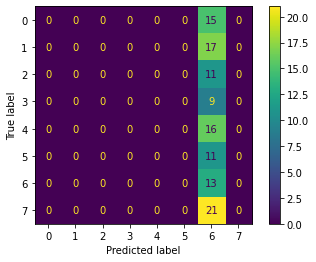

In [ ]:
print(ungend_poly_svm.degree)

# validate the svm
test_range = list(range(len(test_data)))
print(len(test_range))
accu = 0

for i in test_range:
  res = ungend_poly_svm.predict([test_data[i]])
  if res[0] == test_labels[i]:
    accu += 1/len(test_range)
print(accu)

# confusion matrix
confu_mat = ConfusionMatrixDisplay.from_estimator(ungend_poly_svm, test_data, test_labels)
#confu_mat.plot()
#plt.show()

In [ ]:
print(train_ten.shape)
import pickle

torch.Size([3037, 9900])


In [ ]:
# save model
pickle.dump(ungend_poly_svm, open('wavelet_mfcc_svm_ungend.sav', 'wb'))

In [ ]:
# inference on actual testing data
# do this to do on tsne embedding instead
#check_data = tsne.fit(check_data)

final_svm_labels = ['']*len(check_data)

for i in range(len(check_data)):
  res = ungend_poly_svm.predict([check_data[i]])[0]
  #print(testnums[i], label_conversion[res])
  final_svm_labels[int(testnums[i][-3:])] = [testnums[i], label_conversion[res]]

# want to sort final labels by the clip number
final_svm_labels.sort(key=lambda y: int(y[0][-3:]))

final_svm_labels = np.array(final_svm_labels)
print(final_svm_labels)

# write to csv
df = pd.DataFrame(final_svm_labels, columns=['filename', 'label'])

[['sample000' 'happy']
 ['sample001' 'neutral']
 ['sample002' 'fearful']
 ['sample003' 'sad']
 ['sample004' 'calm']
 ['sample005' 'fearful']
 ['sample006' 'calm']
 ['sample007' 'surprised']
 ['sample008' 'happy']
 ['sample009' 'disgust']
 ['sample010' 'disgust']
 ['sample011' 'sad']
 ['sample012' 'calm']
 ['sample013' 'angry']
 ['sample014' 'calm']
 ['sample015' 'sad']
 ['sample016' 'fearful']
 ['sample017' 'fearful']
 ['sample018' 'calm']
 ['sample019' 'happy']
 ['sample020' 'calm']
 ['sample021' 'angry']
 ['sample022' 'neutral']
 ['sample023' 'neutral']
 ['sample024' 'happy']
 ['sample025' 'fearful']
 ['sample026' 'calm']
 ['sample027' 'calm']
 ['sample028' 'sad']
 ['sample029' 'surprised']
 ['sample030' 'calm']
 ['sample031' 'angry']
 ['sample032' 'sad']
 ['sample033' 'sad']
 ['sample034' 'disgust']
 ['sample035' 'disgust']
 ['sample036' 'happy']
 ['sample037' 'surprised']
 ['sample038' 'happy']
 ['sample039' 'calm']
 ['sample040' 'happy']
 ['sample041' 'calm']
 ['sample042' 'happy'

In [ ]:
%cd ../..

/


In [ ]:
%cd content

/content


In [ ]:
!pip install pandas==1.3.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 10.6 MB 4.2 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.2
    Uninstalling pandas-1.5.2:
      Successfully uninstalled pandas-1.5.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
audformat 0.15.4 requires pandas>=1.4.1, but you have pandas 1.3.0 which is incompatible.


In [ ]:
#os.chdir('./content')
df.to_csv('w_mfcc_w_lpcc_linear_ungend_svm_.csv', index=False)

#Gendered SVM

In [ ]:
male_poly_svm = svm.SVC(kernel='poly', gamma=1, C=1, decision_function_shape='ovr', degree=2)
male_poly_svm.fit(train_data_m, train_labels_m)

SVC(C=1, degree=2, gamma=1, kernel='poly')

In [ ]:
female_poly_svm = svm.SVC(kernel='poly', gamma=1, C=1, decision_function_shape='ovr', degree=2)
female_poly_svm.fit(train_data_f, train_labels_f)

SVC(C=1, degree=2, gamma=1, kernel='poly')

In [ ]:
# validate male svm
print(male_poly_svm.degree)
test_range = list(range(len(test_data_m)))
print(len(test_range))
accu = 0

for i in test_range:
  res = ungend_poly_svm.predict([test_data_m[i]])
  if res[0] == test_labels_m[i]:
    accu += 1/len(test_range)
print(accu)

2
169
0.9881656804733743


In [ ]:
# validate female svm
test_range = list(range(len(test_data_f)))
print(len(test_range))
accu = 0

for i in test_range:
  res = ungend_poly_svm.predict([test_data_f[i]])
  if res[0] == test_labels_f[i]:
    accu += 1/len(test_range)
print(accu)

169
0.9822485207100606


In [ ]:
print(ungend_poly_svm.predict([check_data[testnums.index('sample008')]])[0])
print(male_poly_svm.predict([check_data[testnums.index('sample008')]])[0])
print(label_conversion)

2
3
['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


In [ ]:
# inference on actual testing data

final_svm_labels = ['']*len(check_data)

# male - maybe try ungend for men because they useless
for i in range(len(check_data_m)):
  res = male_poly_svm.predict([check_data_m[i]])[0]
  #print(testnums[i], label_conversion[res])
  final_svm_labels[int(test_nums_m[i][-3:])] = [test_nums_m[i], label_conversion[res]]

for i in range(len(check_data_f)):
  res = female_poly_svm.predict([check_data_f[i]])[0]
  #print(testnums[i], label_conversion[res])
  final_svm_labels[int(test_nums_f[i][-3:])] = [test_nums_f[i], label_conversion[res]]

# want to sort final labels by the clip number
final_svm_labels.sort(key=lambda y: int(y[0][-3:]))

final_svm_labels = np.array(final_svm_labels)
print(final_svm_labels)

# write to csv
df = pd.DataFrame(final_svm_labels, columns=['filename', 'label'])

[['sample000' 'happy']
 ['sample001' 'calm']
 ['sample002' 'angry']
 ['sample003' 'sad']
 ['sample004' 'fearful']
 ['sample005' 'neutral']
 ['sample006' 'calm']
 ['sample007' 'disgust']
 ['sample008' 'fearful']
 ['sample009' 'disgust']
 ['sample010' 'calm']
 ['sample011' 'angry']
 ['sample012' 'calm']
 ['sample013' 'calm']
 ['sample014' 'calm']
 ['sample015' 'sad']
 ['sample016' 'angry']
 ['sample017' 'disgust']
 ['sample018' 'calm']
 ['sample019' 'sad']
 ['sample020' 'disgust']
 ['sample021' 'surprised']
 ['sample022' 'sad']
 ['sample023' 'angry']
 ['sample024' 'disgust']
 ['sample025' 'disgust']
 ['sample026' 'sad']
 ['sample027' 'calm']
 ['sample028' 'calm']
 ['sample029' 'happy']
 ['sample030' 'angry']
 ['sample031' 'happy']
 ['sample032' 'disgust']
 ['sample033' 'disgust']
 ['sample034' 'sad']
 ['sample035' 'angry']
 ['sample036' 'angry']
 ['sample037' 'surprised']
 ['sample038' 'angry']
 ['sample039' 'surprised']
 ['sample040' 'disgust']
 ['sample041' 'calm']
 ['sample042' 'happy

In [ ]:
# democracy with all 3 - measures how often all 3 agree

'''
test_range = list(range(len(test_data)))
print(len(test_range))
accu = 0

for i in test_range:
  resf = female_poly_svm.predict([test_data[i]])
  resm = male_poly_svm.predict([test_data[i]])
  resu = ungend_poly_svm.predict([test_data[i]])
  #print(resf, resm, resu)

  res = res if resf == resm == resu else [random.choice(range(8))]

  if res[0] == test_labels[i]:
    accu += 1/len(test_range)
print(accu)
# conclusion: agrees correctly 0% of the time
'''

'\ntest_range = list(range(len(test_data)))\nprint(len(test_range))\naccu = 0\n\nfor i in test_range:\n  resf = female_poly_svm.predict([test_data[i]])\n  resm = male_poly_svm.predict([test_data[i]])\n  resu = ungend_poly_svm.predict([test_data[i]])\n  #print(resf, resm, resu)\n\n  res = res if resf == resm == resu else [random.choice(range(8))]\n\n  if res[0] == test_labels[i]:\n    accu += 1/len(test_range)\nprint(accu)\n# conclusion: agrees correctly 0% of the time\n'

# Feature selection by training buncha SVMs

## Training Code

In [ ]:
!pwd
# RFE:
# first we train a bunch of SVMs using each feature (or subset)
# pick the one with highest acc
# compute correlation to all others, remove those below threshold
# pick one with next highest acc, repeat until # of desired features is achieved

# to use n features for an svm could just concat them and project dim down to that of 1 vector

# feature list is smile.feature_names
#smile_features = torch.load('smile_features.pt')
from sklearn.ensemble import RandomForestClassifier

/content/data/data


In [ ]:
print(len(smile_features), smile_features[0].shape)
print(len(smile.feature_names))
print(np.array(smile_matrices).shape)

featsel_model = RandomForestClassifier

1125 (88, 1)
88
(88, 1125, 1)


In [ ]:
# assume that the features are loaded up properly
# iterate thru each feature, train an svm, record and print accuracy
# just try 1 feature at a time for now
kernel = 'rbf'
gamma = 'scale'

feature_accuracies = [1]*len(smile.feature_names)
feature_svms = [1] *len(smile.feature_names) # FICKS THIS FROM SMILE FEATURES TO SMILE MATRICES (is this even necessary)
feature_preds = [1]*len(smile.feature_names)

# set up their own dataloaders
for i in range(len(smile.feature_names)):
  # after processing we can write dataloaders
  # remember that data mat is the cepstrum matrix (for now)

  # train test split like the other ones
  featsel_train_data, featsel_test_data, train_labels, test_labels = train_test_split(smile_matrices[i],
                                                                      emo_labels, train_size=0.9)#, random_state=np.random.RandomState())

  # train the svm and validate right here
  # feature_svm = svm.SVC(kernel=kernel, C=1, decision_function_shape='ovr', 
  #                       degree=2, class_weight='balanced', max_iter=1e6, gamma=gamma)
  feature_svm = featsel_model(max_depth=25)
  feature_svm.fit(featsel_train_data, train_labels)
  feature_svms[i] = feature_svm

  # validate
  test_range = list(range(len(featsel_test_data)))
  print(len(test_range), len(test_labels))
  feat_accu = 0

  # predict on the specific feature
  feat_res = feature_svm.predict(featsel_test_data)
  feature_preds[i] = feat_res

  for j in test_range:
    res = feat_res[j]
    #print(res, len(test_labels))
    if res == test_labels[j]:
      feat_accu += 1/len(test_range)
  print(smile.feature_names[i], feat_accu)
  feature_accuracies[i] = feat_accu

113 113
F0semitoneFrom27.5Hz_sma3nz_amean 0.1415929203539823
113 113
F0semitoneFrom27.5Hz_sma3nz_stddevNorm 0.09734513274336283
113 113
F0semitoneFrom27.5Hz_sma3nz_percentile20.0 0.09734513274336283
113 113
F0semitoneFrom27.5Hz_sma3nz_percentile50.0 0.11504424778761062
113 113
F0semitoneFrom27.5Hz_sma3nz_percentile80.0 0.15929203539823011
113 113
F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2 0.11504424778761062
113 113
F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope 0.1415929203539823
113 113
F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope 0.07964601769911504
113 113
F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope 0.16814159292035402
113 113
F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope 0.07964601769911504
113 113
loudness_sma3_amean 0.16814159292035402
113 113
loudness_sma3_stddevNorm 0.18584070796460184
113 113
loudness_sma3_percentile20.0 0.17699115044247793
113 113
loudness_sma3_percentile50.0 0.23008849557522137
113 113
loudness_sma3_percentile80.0 0.1504424778761062
113 113
loudness_sma3_pctl

In [ ]:
def cauchy_schw(signal_a, signal_b): # BAD, WE DON'T CARE ABOUT THE VALUES OF THESE NUMBERS ACTUALLY
  # compute dot div by mag
  denom = np.linalg.norm(signal_a)* np.linalg.norm(signal_b)
  num = np.dot(signal_a, signal_b)
  return num/denom

def ptwise_sim(signal_a, signal_b):
  # assume signals have same length
  return sum([1 if a==b else 0 for a, b in zip(signal_a, signal_b)])/len(signal_a)

Accuracy-based instead of feature-based code is sus.

In [ ]:
# recursive feature elimination
picked_features = []
copied_features = smile.feature_names.copy()
feature_n = 5
corr_thresh = 0.5/(.4) # higher the picked acc the higher the corr will be. higher the picked acc the less desirable high rem acc becomes
# we use 0.5 corr as a starting place (because correlating half the data means half new things, assuming half goes into wrong)
# then we assume 60% accuracy for standard svm hence 1-.6 = .4
# higher the acc the more lenient we want to be

# want to pick from full list, take out one, pick from the rest, take out more, and pick from the rest again
while len(copied_features) > 0:
  # take the highest acc (save the indices of smile feature names)
  #picked_features = copied_features.index(max(copied_features))
  # these are sourced from static indices, don't look at copied_acc's indices
  copied_acc = [feature_accuracies[smile.feature_names.index(f)] for f in copied_features]

  # remove and add it to picked feature list - hopefully these both pick the first one if tie
  picked_acc = max(copied_acc)
  picked_ind = smile.feature_names.index(copied_features[copied_acc.index(picked_acc)]) # the static not changing index
  # ^ pick the highest acc among available features -> translate it to ind of all features
  picked_features.append(smile.feature_names[picked_ind]) # here we remove the element not the index
  copied_features.remove(smile.feature_names[picked_ind])
  print("picked and removed", smile.feature_names[picked_ind])
  #copied_acc.remove(copied_acc.index(picked_acc))
  adjusted_thresh = corr_thresh*(1-picked_acc)
  print("corr threshold", adjusted_thresh)
  print("possible features left:", copied_features)

  # now check correlation between what's left
  # placeholder corr() method for now
  pick_pred = feature_preds[picked_ind]
  for remain_feat in smile.feature_names: # it's skipping indices
    if remain_feat not in copied_features:
      continue
    #remain_ind = feature_accuracies.index(remain_feat)
    # here we iterate over what's left but we use original static indices
    remain_ind = smile.feature_names.index(remain_feat)
    #print(remain_feat, smile.feature_names[remain_ind])
    #print(picked_ind, remain_ind)
  # take predictions of each feature and do cauchy schwarz for correlation
    rem_pred = feature_preds[remain_ind] # can just save predictions from beforehand -- def do this
    # sort by accuracy, then pick the first one that's below correlation threshold
    #corr = cauchy_schw(pick_pred, rem_pred)
    corr = ptwise_sim(pick_pred, rem_pred)
    adjusted_corr = corr/feature_accuracies[remain_ind]#*(1-picked_acc) # not needed here

    print(smile.feature_names[picked_ind], feature_accuracies[picked_ind],
          smile.feature_names[remain_ind], feature_accuracies[remain_ind], corr, adjusted_corr)
    #to_be_sorted = (remain_ind, feature_accuracies[remain_ind], adjusted_corr)

    # remove those higher than threshold
    if adjusted_corr > adjusted_thresh:
      #print("removing", smile.feature_names[remain_ind])
      copied_features.remove(smile.feature_names[remain_ind])



  print(picked_features)
  print()

picked and removed alphaRatio_sma3
corr threshold 0.8075221238938048
possible features left: ['Loudness_sma3', 'hammarbergIndex_sma3', 'slope0-500_sma3', 'slope500-1500_sma3', 'spectralFlux_sma3', 'mfcc1_sma3', 'mfcc2_sma3', 'mfcc3_sma3', 'mfcc4_sma3', 'F0semitoneFrom27.5Hz_sma3nz', 'jitterLocal_sma3nz', 'shimmerLocaldB_sma3nz', 'HNRdBACF_sma3nz', 'logRelF0-H1-H2_sma3nz', 'logRelF0-H1-A3_sma3nz', 'F1frequency_sma3nz', 'F1bandwidth_sma3nz', 'F1amplitudeLogRelF0_sma3nz', 'F2frequency_sma3nz', 'F2bandwidth_sma3nz', 'F2amplitudeLogRelF0_sma3nz', 'F3frequency_sma3nz', 'F3bandwidth_sma3nz', 'F3amplitudeLogRelF0_sma3nz']
alphaRatio_sma3 0.3539823008849561 Loudness_sma3 0.20353982300884965 0.12389380530973451 0.6086956521739127
alphaRatio_sma3 0.3539823008849561 hammarbergIndex_sma3 0.22123893805309747 0.12389380530973451 0.5599999999999997
alphaRatio_sma3 0.3539823008849561 slope0-500_sma3 0.265486725663717 0.1415929203539823 0.533333333333333
alphaRatio_sma3 0.3539823008849561 slope500-1500_

In [ ]:
import random

In [ ]:
a = [1,2,3]
b = [0,1,2,3,4,5]
print([b[i] for i in a])

[1, 2, 3]


In [ ]:
# train a bunch of svms using random combinations of these selected features (using rbf svm - same kind as selection)
n_combos = 9
features_per_set = 1
# make sure len(picked_features) choose features_per_ensemble >> n_combos

combos = [[0]]*n_combos
combo = 0
while combo < n_combos:
  pickrange = random.sample(picked_features, features_per_set) # words
  pickrange = [smile.feature_names.index(i) for i in pickrange] # to go back to static indices
  if pickrange not in combos:
    #print(combo)
    combos[combo] = pickrange
    combo += 1
  else: 
    continue # pick diff

# form data matrices and train svms
for combo in combos:
  # form datamat
  feat_combo_mat = np.hstack([smile_matrices[i] for i in combo])

  for runmode in [0, 2]: # 0 is no, 1 is yes; set range to 1 to turn off PCA
    if runmode == 1:
      # THEN WE TRY PCA'ING
      print("GOING TO PCA")

      pca = PCA(n_components=smile_matrices[0].shape[1]) # to be messed with
      # run PCA
      pca.fit(feat_combo_mat)
      feat_combo_mat = pca.fit_transform(feat_combo_mat)
    if runmode == 2:
      # wavelet
      print("TAKING WAVELET TRANSFORM")
      # get to cols, wavelet each, stack the coeffs together h, stack the rows v, then stack the matrices h
      feat_combo_mat = np.hstack([np.vstack([np.hstack(
          pywt.dwt(smile_matrices[i][j], 'db4', 'reflect')) for j in range(len(smile_matrices[i]))]) for i in combo])


    # train test split like the other ones
    featsel_train_data, featsel_test_data, train_labels, test_labels = train_test_split(feat_combo_mat,
                                                                        emo_labels, train_size=0.9)#, random_state=np.random.RandomState())

    # train the svm and validate right here
    # feature_svm = svm.SVC(kernel='poly', C=1, decision_function_shape='ovr', 
    #                       degree=2, class_weight='balanced', max_iter=1e6, gamma=1)
    feature_svm = featsel_model(max_depth=25*features_per_set)
    feature_svm.fit(featsel_train_data, train_labels)


    # validate
    test_range = list(range(len(featsel_test_data)))
    #print(len(test_range), len(test_labels))
    feat_accu = 0

    # predict on the specific feature
    feat_res = feature_svm.predict(featsel_test_data)
    feature_preds[0] = feat_res

    for j in test_range:
      res = feat_res[j]
      #print(res, len(test_labels))
      if res == test_labels[j]:
        feat_accu += 1/len(test_range)
    print([smile.feature_names[i] for i in combo], feat_accu)
  print()
  

['mfcc1_sma3'] 0.22123893805309747
TAKING WAVELET TRANSFORM
['mfcc1_sma3'] 0.21238938053097356

['mfcc2_sma3'] 0.22123893805309747
TAKING WAVELET TRANSFORM
['mfcc2_sma3'] 0.17699115044247793

['F2bandwidth_sma3nz'] 0.23893805309734528
TAKING WAVELET TRANSFORM
['F2bandwidth_sma3nz'] 0.1415929203539823

['slope0-500_sma3'] 0.2477876106194692
TAKING WAVELET TRANSFORM
['slope0-500_sma3'] 0.265486725663717

['F1frequency_sma3nz'] 0.23008849557522137
TAKING WAVELET TRANSFORM
['F1frequency_sma3nz'] 0.30973451327433654

['F3bandwidth_sma3nz'] 0.22123893805309747
TAKING WAVELET TRANSFORM
['F3bandwidth_sma3nz'] 0.265486725663717

['alphaRatio_sma3'] 0.2920353982300887
TAKING WAVELET TRANSFORM
['alphaRatio_sma3'] 0.2831858407079648

['F1bandwidth_sma3nz'] 0.20353982300884965
TAKING WAVELET TRANSFORM
['F1bandwidth_sma3nz'] 0.20353982300884965

['mfcc4_sma3'] 0.2477876106194692
TAKING WAVELET TRANSFORM
['mfcc4_sma3'] 0.2566371681415931



## Summary
Best features: ['alphaRatio_sma3', 'mfcc4_sma3', 'F1bandwidth_sma3nz']

Best waveleted features: ['F1bandwidth_sma3nz', 'F1frequency_sma3nz', 'alphaRatio_sma3']

# Feature selection using PCA 

(concat all the features together and PCA to the acceptable dimension)

In this case, we don't pick features to train, we just take the PCA'd eigenvectors and train the model on that

In [ ]:
# this time we don't have smile_matrices but we just have smile_features (is actually all features sorted by datapt)
smile_concat_matrices = mfcc_mat #[]
pca_dim = 300

for smilept in smile_features:
  smile_concat_matrices.append(np.ndarray.flatten(np.array(smilept)))

pca = PCA(n_components=pca_dim) # or pick any dim
# run PCA
pca.fit(np.array(smile_concat_matrices))
pca_smile_mat = pca.fit_transform(np.array(smile_concat_matrices))
# the rows of this mat should contain the most significant data dimensions from features to be ussed to train

In [ ]:
# could then set as follows:
#mfcc_mat = pca_smile_mat
# if we so desire to keep the same training data matrix

In [ ]:
print(pca_smile_mat.shape)

(2250, 300)


# Test emo model & write to csv (gendered)

In [ ]:
model_m = torch.load('model_resnet_Mfcc_20_epochs.pt')
model_f = torch.load('model_resnet_mFcc_15_epochs.pt')

In [ ]:
model_m.eval()
model_f.eval()

Shallow_ResNet_Template(
  (conv1): Conv1d(1, 64, kernel_size=(7,), stride=(1,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (layer2): Sequential(
    (0): block(
      (conv1): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv1d(128, 128, kernel_size=(3,), stride=(2,), padding=(1,))
      (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv1d(128, 512, kernel_size=(1,), stride=(1,))
      (bn3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv1d(64, 512, kernel_size=(1,), stride=(2,))
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (layer3): Sequential(
    (0): block(
      (conv1): 

In [ ]:
print(label_conversion)

['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


In [ ]:
mm_count = [0]*8
ff_count = [0]*8
for thing in emo_labels_m:
  mm_count[thing] += 1
for thing in emo_labels_f:
  ff_count[thing] += 1

print("male emotion count:", mm_count)
print("female emotion count:", ff_count)

male emotion count: [73, 72, 74, 80, 73, 38, 77, 76]
female emotion count: [77, 78, 76, 70, 77, 37, 73, 74]


In [ ]:
# EMERGENCY CODE -- ONLY RUN IF WANT TO RESTART FOLLOWING CELL
#%cd test/test

[Errno 2] No such file or directory: 'test/test'
/content/test/test


Male

In [ ]:
#os.chdir('test/test')

# old neutral
# convert numpy ndarray format into tensors
check_ten_m = torch.tensor(check_data_m)#.cuda()

check_pred_m = model_m(check_ten_m)
print(check_pred_m)
print()

# get predictions
check_predictions_m = [label_conversion[list(check_pred_m[i]).index(max(check_pred_m[i]))]
     for i in range (len(check_pred_m))]
print(check_predictions_m)
print(list(check_pred_m[i]).index(max(check_pred_m[i]))
     for i in range (len(check_pred_m)))

test_numbers_m = [int(word[6:]) for word in test_nums_m]

final_labels_gend = ['']*check_data.shape[0]

# show them in order
for i in range(len(check_pred_m)): # go from 0 to len
  cp = check_predictions_m[i] # corresponding to ith clip in testnums

  print(i, test_nums_m[i], cp, list(check_pred_m[i]).index(max(check_pred_m[i])))
  final_labels_gend[test_numbers_m[i]] = [test_nums_m[i], cp]

#print(final_labels)

# want to sort final labels by the clip number
#final_labels_gend.sort(key=lambda y: int(y[0][-3:]))

#final_labels_gend = np.array(final_labels_gend)
print(final_labels_gend)

'''
new_list = [('john', 6), ('Micheal', 9), ('George', 2), ('steve', 19)]

new_list.sort(key=lambda y: y[1])

print(new_list)'''

# write to csv

#df = pd.DataFrame(final_labels, columns=['filename', 'label'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


tensor([[ -0.5288,  -2.2078,   2.4136,  ...,  -2.1994,   4.6390,  -1.7135],
        [  3.2362,  -9.6785,  -0.8144,  ...,  -2.4465,  -0.5857,   2.1397],
        [ -7.8149,   7.1419,  -0.7266,  ...,   2.0862,   3.2554,   0.6037],
        ...,
        [  9.1822, -17.6304,   0.4916,  ...,  -4.4373,  -7.7535,   6.6869],
        [  7.1902, -12.4292,  -1.1877,  ...,  -6.2862,  -2.4180,   3.2722],
        [  2.1998,  -9.9128,   1.6006,  ...,  -5.5090,  -5.7367,   5.9970]],
       dtype=torch.float64, grad_fn=<AddmmBackward0>)

['sad', 'fearful', 'calm', 'happy', 'happy', 'neutral', 'calm', 'angry', 'surprised', 'neutral', 'calm', 'fearful', 'disgust', 'calm', 'calm', 'happy', 'happy', 'angry', 'surprised', 'angry', 'surprised', 'happy', 'fearful', 'calm', 'angry', 'happy', 'disgust', 'fearful', 'calm', 'angry', 'angry', 'disgust', 'angry', 'disgust', 'calm', 'happy', 'angry', 'disgust', 'happy', 'surprised', 'angry', 'neutral', 'happy', 'calm', 'fearful', 'sad', 'angry', 'calm', 'surprised', '

"\nnew_list = [('john', 6), ('Micheal', 9), ('George', 2), ('steve', 19)]\n\nnew_list.sort(key=lambda y: y[1])\n\nprint(new_list)"

Female

In [ ]:
# old neutral
# convert numpy ndarray format into tensors
check_ten_f = torch.tensor(check_data_f).cuda()

check_pred_f = model_f(check_ten_f)
print(check_pred_f)
print()

# get predictions
check_predictions_f = [label_conversion[list(check_pred_f[i]).index(max(check_pred_f[i]))]
     for i in range (len(check_pred_f))]
print(check_predictions_f)
print(list(check_pred_f[i]).index(max(check_pred_f[i]))
     for i in range (len(check_pred_f)))

test_numbers_f = [int(word[6:]) for word in test_nums_f]


# show them in order
for i in range(len(check_pred_f)): # go from 0 to len
  cp = check_predictions_f[i] # corresponding to ith clip in testnums

  print(i, test_nums_f[i], cp, list(check_pred_f[i]).index(max(check_pred_f[i])))
  final_labels_gend[test_numbers_f[i]] = [test_nums_f[i], cp]

#print(final_labels)

# want to sort final labels by the clip number
final_labels_gend.sort(key=lambda y: int(y[0][-3:]))

final_labels_gend = np.array(final_labels_gend)
print(final_labels_gend)

# write to csv
df = pd.DataFrame(final_labels_gend, columns=['filename', 'label'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


tensor([[ 4.7949, -5.6174,  2.8495,  ..., -3.5512,  0.0763,  0.1473],
        [-2.9841, -4.3897, 10.3978,  ..., -4.3340,  6.5570, -3.3760],
        [-8.3252,  5.2529, -3.1629,  ...,  3.4237,  4.3120, -3.4661],
        ...,
        [-9.7868,  1.6903, -1.7917,  ...,  1.7037,  7.9871, -6.9077],
        [-0.6218, -1.2689,  1.0057,  ..., -0.2886,  2.2308, -1.6569],
        [-3.7279,  7.6364, -0.1273,  ...,  5.2507,  5.0175, -7.2235]],
       device='cuda:0', dtype=torch.float64, grad_fn=<AddmmBackward0>)

['angry', 'disgust', 'calm', 'fearful', 'fearful', 'angry', 'surprised', 'fearful', 'angry', 'angry', 'sad', 'disgust', 'disgust', 'disgust', 'fearful', 'neutral', 'angry', 'calm', 'fearful', 'calm', 'fearful', 'calm', 'angry', 'disgust', 'fearful', 'calm', 'happy', 'sad', 'calm', 'angry', 'happy', 'angry', 'disgust', 'fearful', 'neutral', 'sad', 'disgust', 'disgust', 'fearful', 'angry', 'calm', 'fearful', 'sad', 'angry', 'sad', 'sad', 'sad', 'fearful', 'fearful', 'surprised', 'calm', 'dis

#Ungendered - indices are ficksed

In [ ]:
from google.colab import files
files.download('wmfcc_mlp_25_epochs.pt') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pwd
#%cd ../..

/content


In [ ]:
!pip install pandas==1.3.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 10.6 MB 35.8 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.2
    Uninstalling pandas-1.5.2:
      Successfully uninstalled pandas-1.5.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
audformat 0.15.4 requires pandas>=1.4.1, but you have pandas 1.3.0 which is incompatible.


In [ ]:
#os.chdir('../..')
df.to_csv('semiglob_attn_w_mfcc_85_redo.csv', index=False)

In [ ]:
print(testnums)

['sample090', 'sample136', 'sample258', 'sample049', 'sample277', 'sample157', 'sample099', 'sample042', 'sample273', 'sample307', 'sample052', 'sample064', 'sample193', 'sample128', 'sample163', 'sample083', 'sample066', 'sample264', 'sample142', 'sample271', 'sample241', 'sample266', 'sample284', 'sample190', 'sample029', 'sample115', 'sample006', 'sample114', 'sample269', 'sample275', 'sample208', 'sample152', 'sample279', 'sample073', 'sample084', 'sample296', 'sample255', 'sample093', 'sample151', 'sample095', 'sample132', 'sample313', 'sample167', 'sample040', 'sample238', 'sample050', 'sample082', 'sample037', 'sample155', 'sample259', 'sample045', 'sample107', 'sample234', 'sample186', 'sample235', 'sample031', 'sample198', 'sample105', 'sample012', 'sample227', 'sample153', 'sample244', 'sample171', 'sample075', 'sample001', 'sample139', 'sample013', 'sample027', 'sample294', 'sample182', 'sample024', 'sample300', 'sample270', 'sample119', 'sample035', 'sample127', 'sample103'

In [ ]:
model.train()

CNN_2D_Template(
  (block1): Res_Atten_Conv2D_Block(
    (conv1): Conv2d(1, 32, kernel_size=(5, 31), stride=(1, 3))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): Conv2d(32, 64, kernel_size=(3, 1), stride=(1, 1))
    (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample_gap): AdaptiveAvgPool2d(output_size=(8, 8))
    (conv2): Conv2d(32, 64, kernel_size=(3, 7), stride=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (gap2): AdaptiveAvgPool2d(output_size=(8, 8))
    (gelu): GELU(approximate='none')
  )
  (fc1): Linear(in_features=4096, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=512, bias=True)
  (fclast): Linear(in_features=512, out_features=8, b

In [ ]:
# if loaded model
model.eval()

CNN_2D_Template(
  (block1): Res_Atten_Conv2D_Block(
    (conv1): Conv2d(1, 32, kernel_size=(5, 31), stride=(1, 3))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): Conv2d(32, 64, kernel_size=(3, 1), stride=(1, 1))
    (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample_gap): AdaptiveAvgPool2d(output_size=(8, 8))
    (conv2): Conv2d(32, 64, kernel_size=(3, 7), stride=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (gap2): AdaptiveAvgPool2d(output_size=(8, 8))
    (gelu): GELU(approximate='none')
  )
  (fc1): Linear(in_features=4096, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=512, bias=True)
  (fclast): Linear(in_features=512, out_features=8, b

In [ ]:
# old neutral
# convert numpy ndarray format into tensors

check_ten = torch.tensor(check_data).cuda()

check_pred = model.cuda()(check_ten)
print(check_pred)
print()

# get predictions
check_predictions = [label_conversion[list(check_pred[i]).index(max(check_pred[i]))]
     for i in range (len(check_pred))]
print(check_predictions)
print(list(check_pred[i]).index(max(check_pred[i]))
     for i in range (len(check_pred)))

test_nums = [int(word[6:]) for word in testnums]

final_labels = ['']*check_data.shape[0]

# show them in order
for i in range(len(check_pred)): # go from 0 to len
  cp = check_predictions[i] # corresponding to ith clip in testnums

  print(i, testnums[i], cp, list(check_pred[i]).index(max(check_pred[i])))
  final_labels[test_nums[i]] = [testnums[i], cp]

#print(final_labels)

# want to sort final labels by the clip number
final_labels.sort(key=lambda y: int(y[0][6:]))

final_labels = np.array(final_labels)
print(final_labels)

'''
new_list = [('john', 6), ('Micheal', 9), ('George', 2), ('steve', 19)]

new_list.sort(key=lambda y: y[1])

print(new_list)'''

# write to csv

df = pd.DataFrame(final_labels, columns=['filename', 'label'])

OutOfMemoryError: ignored